<b>Project: Hit or miss</b><br>
<br>
Predicting whether a Spotify song is a flop or a hit.

In [1]:
!pip install progressbar

In [2]:
!pip install gender_guesser

In [3]:
!pip install dtreeviz

In [4]:
import os
import math
import warnings
import itertools
from timeit import default_timer as timer

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup 
import re
import time
import progressbar

from sklearn.model_selection import cross_val_score, train_test_split,cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,auc,confusion_matrix
from sklearn.impute import KNNImputer

from dtreeviz.trees import dtreeviz

import seaborn as sns



<br><b>Loading The Data</b><br>
Since our data set is comprised of 6 different csv files (A file for each decade), we will iterate over them and combine them, while using the decade as an additional feature.

In [5]:

warnings.filterwarnings('ignore')

baseFilePath = "data"
list_of_files = os.listdir(baseFilePath)
first_run = True
for file in list_of_files:
    if '.csv' in file:
        full_path = os.path.join(baseFilePath,file)
        print(f"Found matching file: {full_path}")
        fileDecade = file[-7:-5]
        
        
        df = pd.read_csv(full_path)
        if fileDecade in ('00','10'):
            decade_year=int('20'+fileDecade)
        else:
            decade_year=int('19'+fileDecade)
        
        df['decade']=decade_year
        print(f"Decade: {decade_year}. Num Of Records: {df.shape[0]}\n")   
        
        
        if first_run:
            data = df
            first_run = False
        else:
            data = data.append(df, ignore_index=True)
        
        
print(f"Total Number of {data.shape[0]} records with {data.shape[1]} different columns")

Found matching file: data\dataset-of-00s.csv
Decade: 2000. Num Of Records: 5872

Found matching file: data\dataset-of-10s.csv
Decade: 2010. Num Of Records: 6398

Found matching file: data\dataset-of-60s.csv
Decade: 1960. Num Of Records: 8642

Found matching file: data\dataset-of-70s.csv
Decade: 1970. Num Of Records: 7766

Found matching file: data\dataset-of-80s.csv
Decade: 1980. Num Of Records: 6908

Found matching file: data\dataset-of-90s.csv
Decade: 1990. Num Of Records: 5520

Total Number of 41106 records with 20 different columns


<br><b>Adding External Data</b><br>
In order to further explore the data we will try to seek additional information about the Artists.<br>
To do so, we will use the trackId of each song and build a scraper that will:<br>
* Run over the list of trackIds.
* Find the track URL on spotify.
* Extract the artist URL based on the track.
* Extract the Artist Info from the artist page
* Based on the pronounses in the info - Determine whether the artist is a Female, Male or a Band.

** Since this required a cursor that performed over 80,000 calls to Spotify, we will not performed the scraping here, and instead attached the pre-created output files.<br>
For more details about the process and the code, please find an additional 'Gender Reveal' notebook attached.

In [6]:
warnings.filterwarnings('ignore')

baseFilePath = "data_with_gender"
list_of_files = os.listdir(baseFilePath)
first_run = True
for file in list_of_files:
    if '.csv' in file:
        full_path = os.path.join(baseFilePath,file)
        print(f"Found matching file: {full_path}")
        fileDecade = file[-7:-5]
        
        
        df = pd.read_csv(full_path)
        if fileDecade in ('00','10'):
            decade_year=int('20'+fileDecade)
        else:
            decade_year=int('19'+fileDecade)
        
        df['decade']=decade_year
        print(f"Decade: {decade_year}. Num Of Records: {df.shape[0]}\n")   
        
        
        if first_run:
            data = df
            first_run = False
        else:
            data = data.append(df, ignore_index=True)
        
# Rename the values to provide full gender description
data['artist_gender']
data.loc[data["artist_gender"] == "M", "artist_gender"] = "Male"
data.loc[data["artist_gender"] == "F", "artist_gender"] = "Female"

print(f"Total Number of {data.shape[0]} records with {data.shape[1]} different columns")

Found matching file: data_with_gender\gendered-dataset-of-00s.csv
Decade: 2000. Num Of Records: 5872

Found matching file: data_with_gender\gendered-dataset-of-10s.csv
Decade: 2010. Num Of Records: 6398

Found matching file: data_with_gender\gendered-dataset-of-60s.csv
Decade: 1960. Num Of Records: 8642

Found matching file: data_with_gender\gendered-dataset-of-70s.csv
Decade: 1970. Num Of Records: 7766

Found matching file: data_with_gender\gendered-dataset-of-80s.csv
Decade: 1980. Num Of Records: 6908

Found matching file: data_with_gender\gendered-dataset-of-90s.csv
Decade: 1990. Num Of Records: 5520

Total Number of 41106 records with 21 different columns


<br><b>Observing The Data</b><br>
We will go over our different columns, make note of their scales and divide them into columns types for later preprocessing.

In [7]:
data.head(5)

,track,artist,artist_gender,uri,danceability,energy,key,loudness,mode,speechiness,...,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
0,Lucky Man,Montgomery Gentry,Band,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,...,0.00000,0.159,0.532,133.061,196707,4,30.88059,13,1,2000
1,On The Hotline,Pretty Ricky,unknown,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,...,0.00000,0.148,0.688,92.988,242587,4,41.51106,10,1,2000
2,Clouds Of Dementia,Candlemass,unknown,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,0.162,0.836,9,-3.009,1,0.0473,...,0.00457,0.174,0.300,86.964,338893,4,65.32887,13,0,2000
3,"Heavy Metal, Raise Hell!",Zwartketterij,unknown,spotify:track:2IjBPp2vMeX7LggzRN3iSX,0.188,0.994,4,-3.745,1,0.1660,...,0.07840,0.192,0.333,148.440,255667,4,58.59528,9,0,2000
4,I Got A Feelin',Billy Currington,Male,spotify:track:1tF370eYXUcWwkIvaq3IGz,0.630,0.764,2,-4.353,1,0.0275,...,0.00000,0.125,0.631,112.098,193760,4,22.62384,10,1,2000


In [8]:
data.describe().round(3)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
count,41106.000,41106.000,41106.000,41106.000,41106.000,41106.000,41106.000,41106.000,41106.000,41106.000,41106.000,41106.000,41106.000,41106.000,41106.000,41106.0,41106.000
mean,0.540,0.580,5.214,-10.222,0.693,0.073,0.364,0.154,0.202,0.542,119.338,234877.550,3.894,40.106,10.476,0.5,1982.775
std,0.178,0.253,3.535,5.312,0.461,0.086,0.339,0.304,0.173,0.267,29.099,118967.398,0.423,19.006,4.872,0.5,17.491
min,0.000,0.000,0.000,-49.253,0.000,0.000,0.000,0.000,0.013,0.000,0.000,15168.000,0.000,0.000,0.000,0.0,1960.000
25%,0.420,0.396,2.000,-12.816,0.000,0.034,0.039,0.000,0.094,0.330,97.397,172927.750,4.000,27.600,8.000,0.0,1970.000
50%,0.552,0.601,5.000,-9.257,1.000,0.043,0.258,0.000,0.132,0.558,117.565,217907.000,4.000,35.851,10.000,0.5,1980.000
75%,0.669,0.787,8.000,-6.374,1.000,0.070,0.676,0.061,0.261,0.768,136.494,266773.000,4.000,47.626,12.000,1.0,2000.000
max,0.988,1.000,11.000,3.744,1.000,0.960,0.996,1.000,0.999,0.996,241.423,4170227.000,5.000,433.182,169.000,1.0,2010.000


<br><b>Find Categorical Data:</b><br>
Look for a column with less than 20 unique values.<br>

In [9]:
for col in data.columns:
    print(f"Column: {col}.    Unique Values: {len(data[col].unique())}")
    if len(data[col].unique())<20:
        print(f"           This is a categorical type column with {len(data[col].unique())} unique values:\n            {data[col].unique()}")

Column: track.    Unique Values: 35860
Column: artist.    Unique Values: 11904
Column: artist_gender.    Unique Values: 4
           This is a categorical type column with 4 unique values:
            ['Band' 'unknown' 'Male' 'Female']
Column: uri.    Unique Values: 40560
Column: danceability.    Unique Values: 1048
Column: energy.    Unique Values: 1787
Column: key.    Unique Values: 12
           This is a categorical type column with 12 unique values:
            [ 4 10  9  2 11  1  7  8  0  3  5  6]
Column: loudness.    Unique Values: 16160
Column: mode.    Unique Values: 2
           This is a categorical type column with 2 unique values:
            [1 0]
Column: speechiness.    Unique Values: 1346
Column: acousticness.    Unique Values: 4194
Column: instrumentalness.    Unique Values: 5122
Column: liveness.    Unique Values: 1674
Column: valence.    Unique Values: 1609
Column: tempo.    Unique Values: 32152
Column: duration_ms.    Unique Values: 21517
Column: time_signature.    

<br>Upon looking at our data we can split it into the following types:<br>
1. Textual Columns - We will not be able to use them as they appear currently and they will be dropped for now.<br>
2. Numerical Columns - We will need to scale these later on.
3. Categorical Columns - We will need to convert these using One-Hot-Encoding.
4. Binary Columns
5. Result Column - This contain our Y values

In [10]:
columns_to_drop = ['track','artist','uri']
categorical_columns = ['key','time_signature','decade','artist_gender']
binary_columns = ['mode']
numerical_columns = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'chorus_hit','sections']
y_column = ['target']

predictor_columns = categorical_columns + binary_columns + numerical_columns
print(f"Our Dataset has: \n  {len(categorical_columns)} categorical_columns. \n  {len(binary_columns)} binary_columns. \n  {len(numerical_columns)} numerical_columns. \n  Total: {len(predictor_columns)} predictor_columns.")

Our Dataset has: 
  4 categorical_columns. 
  1 binary_columns. 
  12 numerical_columns. 
  Total: 17 predictor_columns.


In [11]:
X = data[predictor_columns].copy()
y = data['target']

<br><b>Data Balance</b><br>
We will observe the ratio in our y values, in addition to our categorical and binary columns, and observe if there is an imbalance that requires intervention.


In [12]:
print(f"Flops Count: {y.value_counts()[0]} \nHits  Count: {y.value_counts()[1]}")

Flops Count: 20553 
Hits  Count: 20553


An interesting find we have here is regarding our Y label, which is perfectly balanced<br>
This isn't necessarily a positive thing since it means that the data was most likely collected with the intent of finding equal amount of Hits and Flops<br>
This can indicate a potential bias in the data collection (e.g - 20,553 is ALL the hits from the past 6 decades, while 20,553 flops is just a small sample from an endless population of flops) <br>

<br>Next, we will look at the categorical and binary data distribution and try to find imbalances. <br><br>
There also appear to be an imbalance with the majority of our categorical data, the most notable being time_signature with a high frequency of value 5.<br>
This will need to be re-examined once we build our model and estimate the feature importance.


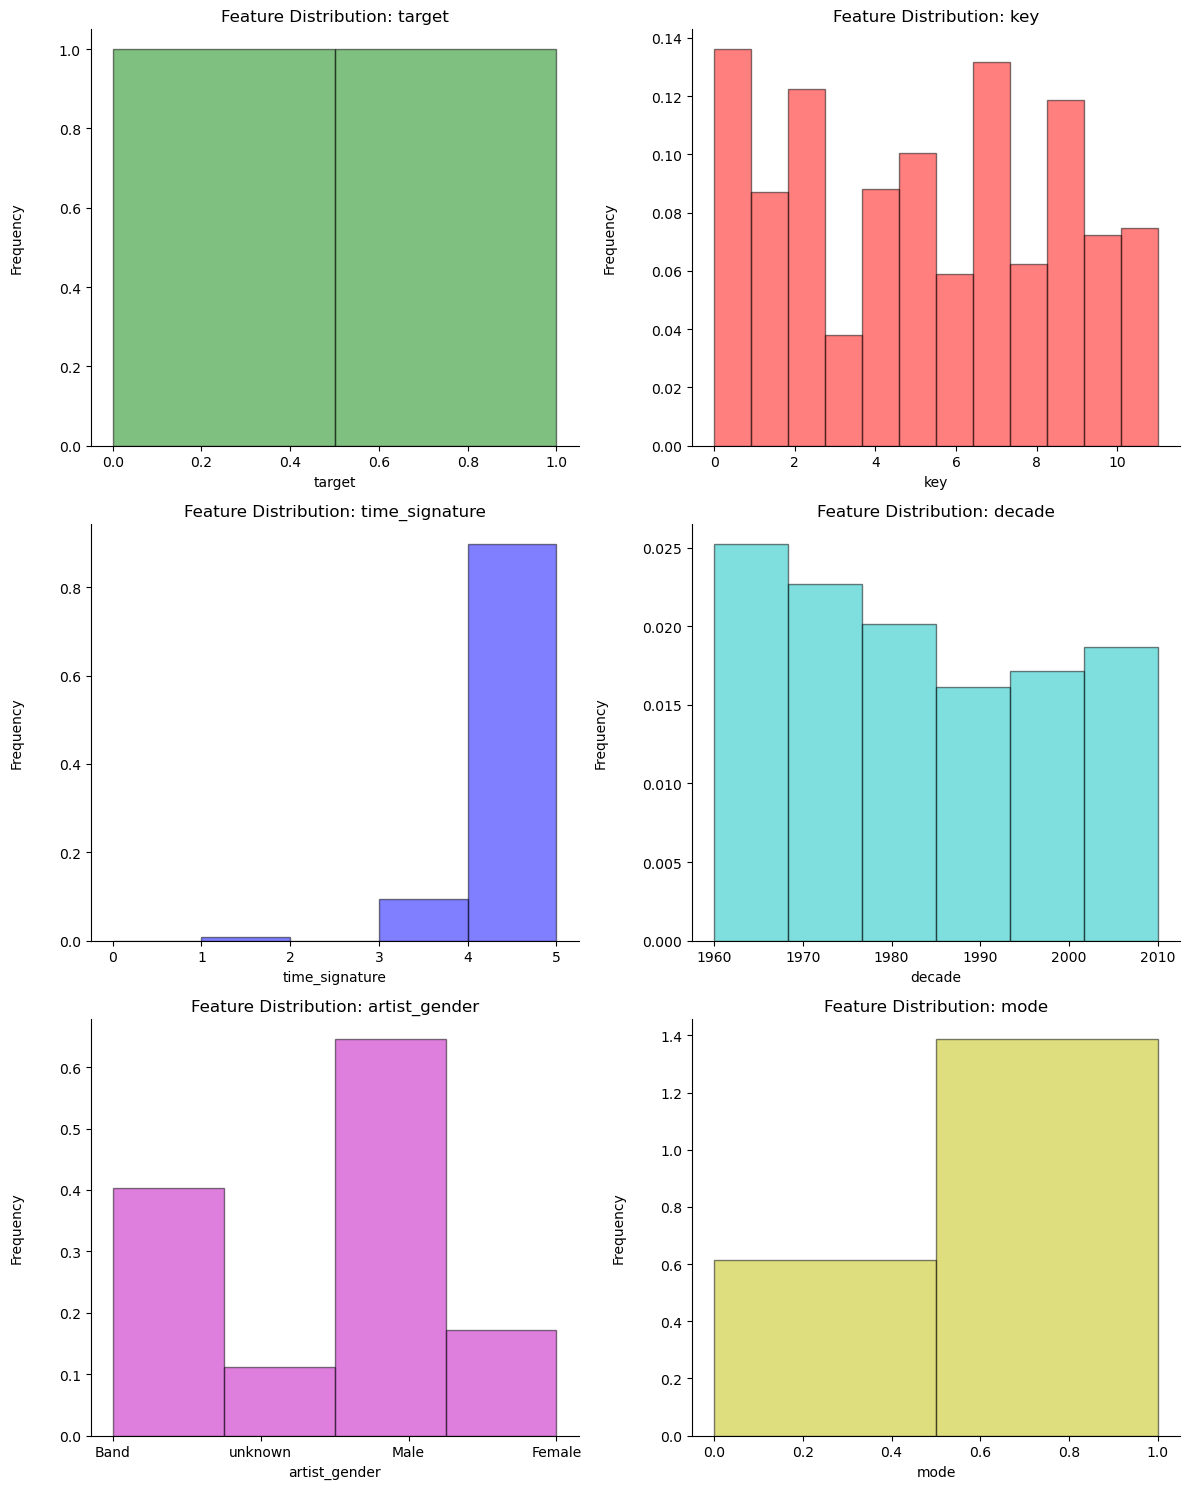

In [13]:
cols_for_histogram = y_column+categorical_columns +binary_columns
feature_num = len(cols_for_histogram)

plot_per_row = 2
row_num = math.ceil(feature_num/plot_per_row)

fig = plt.gcf()
fig.set_size_inches(12,15)

c_list = ['g','r','b','c','m','y','k','tab:pink']


for i,col in enumerate(cols_for_histogram):
    
    col_vals = data[[col]]
    col_vals_series = data[col]
    unique_vals = len(col_vals_series.unique())
    
    bin_start = min(col_vals.min())
    bin_end = max(col_vals.max())
    if col=="artist_gender":
        bin_start=0
        bin_end=3
    bins = np.linspace(bin_start, bin_end, unique_vals+1)
    
    
    ax = fig.add_subplot(row_num,plot_per_row,i+1)
    height, bins, patches = ax.hist(col_vals, bins, alpha=0.5, label=f"Feature {col}",density=True,edgecolor='k', color=c_list[i])
    #ax.legend(loc='upper left',fontsize=16)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency',rotation=90,labelpad=25)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(f'Feature Distribution: {col}')

plt.tight_layout()
plt.plot;

<br><b>Predictor Corralation</b><br>
We will observe the relationship between each predictor individually and attempt to see if any noteable correlation are spotted between the feature and whether or not the song is a hit.<br><br>

In the plot below, we can notice some interesting relationships:<br>
1. Dancability - If your song has less than ~0.2 dancability rate you will not become a hit.
2. Loudness - There is a correlation between loudness and success
3. Speechness - If your speech-to-music ration is higher than 0.45 it decreases your odds significantly at having a hit.
4. Duration - The longer your song lasts the fewer people will listen to it again.
5. Sections - The number of sections the particular track has appear to have an effect on its success rate.


In [14]:
color_map = []
for val in y:
    if val==1:
        color_map.append('g')
    else:
        color_map.append('r')

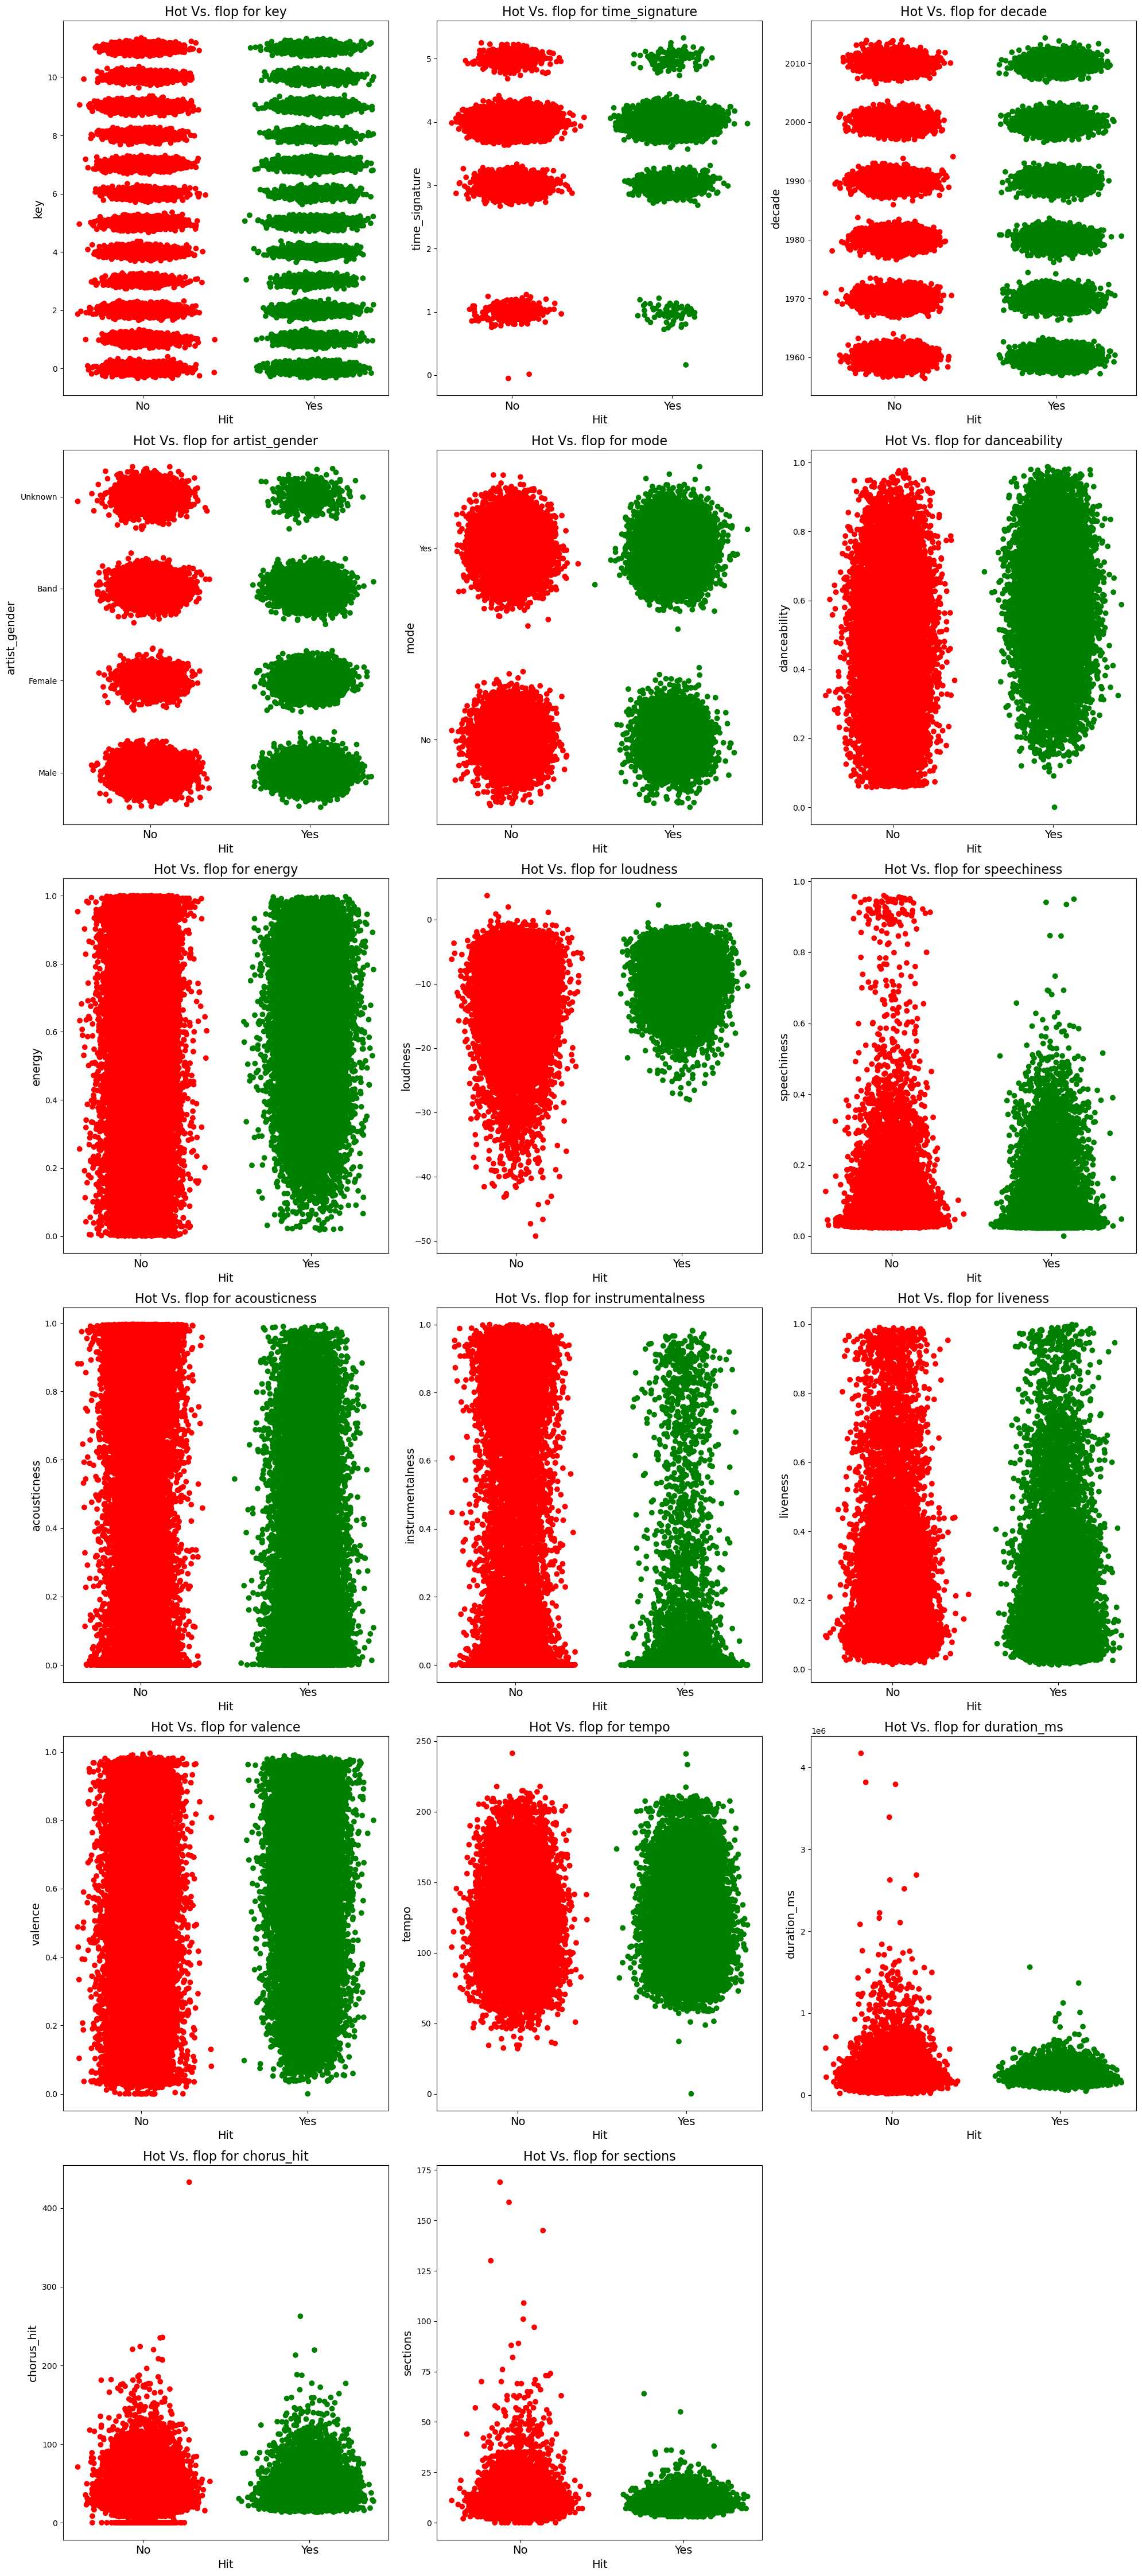

In [15]:
import math

coeff_num = len(predictor_columns)
plot_col_num = 3
row_num = math.ceil(coeff_num/plot_col_num)

fig = plt.gcf()
fig.set_size_inches(20,45)

for i,values in enumerate(predictor_columns):
    
    sigma = 0.1
    
    mu =0.001
    
    # generate normally distributed samples
    y_noise = sigma * np.random.randn(X.shape[0]) + mu
    
    ax = fig.add_subplot(row_num,plot_col_num,i+1)
    x_val = X[values]
    if values in binary_columns:
        x_noise = sigma * np.random.randn(X.shape[0]) + mu
        x_val = X[values]+x_noise
        ax.set_yticks((0,1), labels=('No', 'Yes'))
        
    if values in categorical_columns:
        if values=="decade": # Decade is set in jumps of 10 rather than 1
            sigma = sigma*10 
        x_noise = sigma * np.random.randn(X.shape[0]) + mu
        if values=="artist_gender":
            gender_ints = X[[values]].copy()
            gender_ints.loc[gender_ints["artist_gender"] == "Male", "artist_gender"] = 0
            gender_ints.loc[gender_ints["artist_gender"] == "Female", "artist_gender"] = 1
            gender_ints.loc[gender_ints["artist_gender"] == "Band", "artist_gender"] = 2
            gender_ints.loc[gender_ints["artist_gender"] == "unknown", "artist_gender"] = 3
            x_val = gender_ints[values]+x_noise
            ax.set_yticks(range(len(X[values].unique())), labels=['Male','Female','Band','Unknown'])
        else:
            x_val = X[values]+x_noise
    
    ax.scatter(y+y_noise,x_val, color=color_map)
    ax.set_ylabel(f'{values}', fontsize=14)
    ax.set_xlabel('Hit', fontsize=14)
    ax.set_xticks((0,1), labels=('No', 'Yes'), fontsize=14)
    ax = plt.gca()
    ax.set_title(f'Hot Vs. flop for {values}').set_size(16)

    
plt.tight_layout()
plt.plot;

<br><b>Data Preprocessing:</b><br>
We will cover the following steps:<br>
1. Look for NaN values.<br>
2. One hot Encode.<br>
3. Split Train-Test.<br>
4. Scale Data (From train to test).<br>

<br><b>Missing Data</b><br>
Luckly our original dataset was built without missing data, which makes our data processing much easier.<br><br>
However, while scraping Spotify we were occasionally unable to retrive data regrading Gender.<br>

We have several options to tackle this:
1. We could assume that the data was Missing completely at random (MCAR).<br>
Meaning - missing artist description on Spotify is NOT related to the artists gender. <br>In that case we can simple randomly fill the missing data or delete the missing rows from our dataset.<br><br>
2. Assume our data is Missing at random (MAR) or Missing not at random (MNAR)<br>
Meaning - There is a reason why certain artists did not have a description or a pronoun in their bio, and this can correlate to their gender.<br>
e.g - Male artists put less emphasis on maintaining their Spotify account and are less likely to fill a detailed bio.<br>
In that case, we will tackle this in the following way:
* Use an imputer to fit the rest of the features.
* Transfor the artist_gender column based on imputer.
* Add additional column indicating that the row had missing data.
<br>
Since our missing data is textual, we will need to first convert it to integers, them compute, then rename it back.<br>
This also means that we can only use n_neighbors=1 since we want round numbers and not decimals.


In [16]:
imputer = KNNImputer(n_neighbors=1)
imputer

KNNImputer(n_neighbors=1)

In [17]:
X_impute = X.copy()
X_impute.loc[X_impute["artist_gender"] == "unknown", "artist_gender"] = np.nan
X_impute.loc[X_impute["artist_gender"] == "Male", "artist_gender"] = 0
X_impute.loc[X_impute["artist_gender"] == "Female", "artist_gender"] = 1
X_impute.loc[X_impute["artist_gender"] == "Band", "artist_gender"] = 2
X_impute.head(5)

,key,time_signature,decade,artist_gender,mode,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,chorus_hit,sections
0,4,4,2000,2,1,0.578,0.471,-7.270,0.0289,0.368000,0.00000,0.159,0.532,133.061,196707,30.88059,13
1,10,4,2000,NaN,0,0.704,0.854,-5.477,0.1830,0.018500,0.00000,0.148,0.688,92.988,242587,41.51106,10
2,9,4,2000,NaN,1,0.162,0.836,-3.009,0.0473,0.000111,0.00457,0.174,0.300,86.964,338893,65.32887,13
3,4,4,2000,NaN,1,0.188,0.994,-3.745,0.1660,0.000007,0.07840,0.192,0.333,148.440,255667,58.59528,9
4,2,4,2000,0,1,0.630,0.764,-4.353,0.0275,0.363000,0.00000,0.125,0.631,112.098,193760,22.62384,10


In [18]:
is_missing_data_series = X_impute["artist_gender"].isna().astype(int)
is_missing_data_series[:10]

0    0
1    1
2    1
3    1
4    0
5    1
6    0
7    0
8    0
9    0
Name: artist_gender, dtype: int32

In [19]:
X_impute = pd.DataFrame(imputer.fit_transform(X_impute), columns=X.columns)
X_impute['is_missing_gender'] = is_missing_data_series

# Add new column to predictor columns
predictor_columns.append('is_missing_gender')
binary_columns.append('is_missing_gender')

X_impute.loc[X_impute["artist_gender"] == 0, "artist_gender"] = "Male"
X_impute.loc[X_impute["artist_gender"] == 1, "artist_gender"] = "Female"
X_impute.loc[X_impute["artist_gender"] == 2, "artist_gender"] = "Band"

X_impute.head(5)

,key,time_signature,decade,artist_gender,mode,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,chorus_hit,sections,is_missing_gender
0,4.0,4.0,2000.0,Band,1.0,0.578,0.471,-7.270,0.0289,0.368000,0.00000,0.159,0.532,133.061,196707.0,30.88059,13.0,0
1,10.0,4.0,2000.0,Male,0.0,0.704,0.854,-5.477,0.1830,0.018500,0.00000,0.148,0.688,92.988,242587.0,41.51106,10.0,1
2,9.0,4.0,2000.0,Male,1.0,0.162,0.836,-3.009,0.0473,0.000111,0.00457,0.174,0.300,86.964,338893.0,65.32887,13.0,1
3,4.0,4.0,2000.0,Male,1.0,0.188,0.994,-3.745,0.1660,0.000007,0.07840,0.192,0.333,148.440,255667.0,58.59528,9.0,1
4,2.0,4.0,2000.0,Male,1.0,0.630,0.764,-4.353,0.0275,0.363000,0.00000,0.125,0.631,112.098,193760.0,22.62384,10.0,0


In [20]:
X = X_impute.copy()

In [21]:
# No Additional features are missing values:
for i,col in enumerate(X.columns):
    num_of_missing_vals = X[col].isna().sum()
    print(f"{i} {col} - num_of_missing_vals: {num_of_missing_vals}")

0 key - num_of_missing_vals: 0
1 time_signature - num_of_missing_vals: 0
2 decade - num_of_missing_vals: 0
3 artist_gender - num_of_missing_vals: 0
4 mode - num_of_missing_vals: 0
5 danceability - num_of_missing_vals: 0
6 energy - num_of_missing_vals: 0
7 loudness - num_of_missing_vals: 0
8 speechiness - num_of_missing_vals: 0
9 acousticness - num_of_missing_vals: 0
10 instrumentalness - num_of_missing_vals: 0
11 liveness - num_of_missing_vals: 0
12 valence - num_of_missing_vals: 0
13 tempo - num_of_missing_vals: 0
14 duration_ms - num_of_missing_vals: 0
15 chorus_hit - num_of_missing_vals: 0
16 sections - num_of_missing_vals: 0
17 is_missing_gender - num_of_missing_vals: 0


<br><b>Remove non-music:</b><br>
As per Kaggle, any datapoint above 0.66 speechness ration is not considered a song, but rather a podcast or lecture.<br>
As such, we would like to filter these out<br>

In [22]:
print(f"Number Of records before: {X.shape[0]}")
num_before = X.shape[0]
records_to_keep = X['speechiness']<=0.66
X = X[records_to_keep]
y_trimmed = []
for i,rec in enumerate(records_to_keep):
    if rec==True:
        y_trimmed.append(y[i])
    
y = pd.Series(y_trimmed)
print(f"Number Of records after: {X.shape[0]}")
print(f"Records dropped: {X.shape[0]} ({X.shape[0]-num_before} dropped)")

Number Of records before: 41106
Number Of records after: 40965
Records dropped: 40965 (-141 dropped)


<br><b>One Hot Encoding</b><br>
We will convert all of our categorical columns into binary columns.

In [23]:
for i,col in enumerate(categorical_columns):
    onehot = pd.get_dummies(X[col], prefix=col)
    if i==0:
        X_ohe = X.join(onehot)
    else:
        X_ohe = X_ohe.join(onehot)
    X_ohe = X_ohe.drop([col], axis=1)
    print(f"Col {col} - Converted into {onehot.shape[1]} hot-encoded columns")
X_ohe

Col key - Converted into 12 hot-encoded columns
Col time_signature - Converted into 5 hot-encoded columns
Col decade - Converted into 6 hot-encoded columns
Col artist_gender - Converted into 3 hot-encoded columns


,mode,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,time_signature_5.0,decade_1960.0,decade_1970.0,decade_1980.0,decade_1990.0,decade_2000.0,decade_2010.0,artist_gender_Band,artist_gender_Female,artist_gender_Male
0,1.0,0.578,0.471,-7.270,0.0289,0.368000,0.000000,0.1590,0.532,133.061,...,0,0,0,0,0,1,0,1,0,0
1,0.0,0.704,0.854,-5.477,0.1830,0.018500,0.000000,0.1480,0.688,92.988,...,0,0,0,0,0,1,0,0,0,1
2,1.0,0.162,0.836,-3.009,0.0473,0.000111,0.004570,0.1740,0.300,86.964,...,0,0,0,0,0,1,0,0,0,1
3,1.0,0.188,0.994,-3.745,0.1660,0.000007,0.078400,0.1920,0.333,148.440,...,0,0,0,0,0,1,0,0,0,1
4,1.0,0.630,0.764,-4.353,0.0275,0.363000,0.000000,0.1250,0.631,112.098,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41101,0.0,0.396,0.795,-6.070,0.2340,0.000928,0.000209,0.1820,0.762,152.943,...,0,0,0,0,1,0,0,1,0,0
41102,0.0,0.621,0.655,-6.281,0.0309,0.050600,0.006260,0.0937,0.690,134.167,...,0,0,0,0,1,0,0,1,0,0
41103,0.0,0.562,0.314,-15.213,0.0298,0.440000,0.000011,0.1060,0.571,166.847,...,0,0,0,0,1,0,0,1,0,0
41104,1.0,0.622,0.781,-6.080,0.0368,0.000101,0.755000,0.3830,0.214,120.051,...,0,0,0,0,1,0,0,1,0,0


<br><b>Feature Correlation</b><br>
We will check to see if there is any high correlation within our features.<br>
If the correlation is too high, we will drop one of the features.

In [24]:
X_ohe[numerical_columns].corr()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,chorus_hit,sections
danceability,1.000000,0.210435,0.279117,0.166082,-0.264460,-0.301223,-0.116284,0.555219,-0.065110,-0.062123,-0.035979,-0.057677
energy,0.210435,1.000000,0.771745,0.186815,-0.715200,-0.210886,0.160484,0.342161,0.222514,0.009683,0.009309,-0.043318
loudness,0.279117,0.771745,1.000000,0.140109,-0.565070,-0.378581,0.092110,0.271522,0.167547,-0.053121,-0.013816,-0.084529
speechiness,0.166082,0.186815,0.140109,1.000000,-0.142533,-0.084267,0.123368,0.015938,0.063031,0.017567,0.017869,0.001563
acousticness,-0.264460,-0.715200,-0.565070,-0.142533,1.000000,0.206422,-0.034670,-0.194928,-0.178662,-0.070410,-0.012307,-0.016008
instrumentalness,-0.301223,-0.210886,-0.378581,-0.084267,0.206422,1.000000,-0.049705,-0.287714,-0.054680,0.106503,0.048609,0.081076
liveness,-0.116284,0.160484,0.092110,0.123368,-0.034670,-0.049705,1.000000,0.002039,0.026335,0.005445,0.037525,-0.011505
valence,0.555219,0.342161,0.271522,0.015938,-0.194928,-0.287714,0.002039,1.000000,0.107634,-0.174127,-0.059376,-0.135529
tempo,-0.065110,0.222514,0.167547,0.063031,-0.178662,-0.054680,0.026335,0.107634,1.000000,-0.024326,-0.056755,0.025483
duration_ms,-0.062123,0.009683,-0.053121,0.017567,-0.070410,0.106503,0.005445,-0.174127,-0.024326,1.000000,0.093485,0.887124


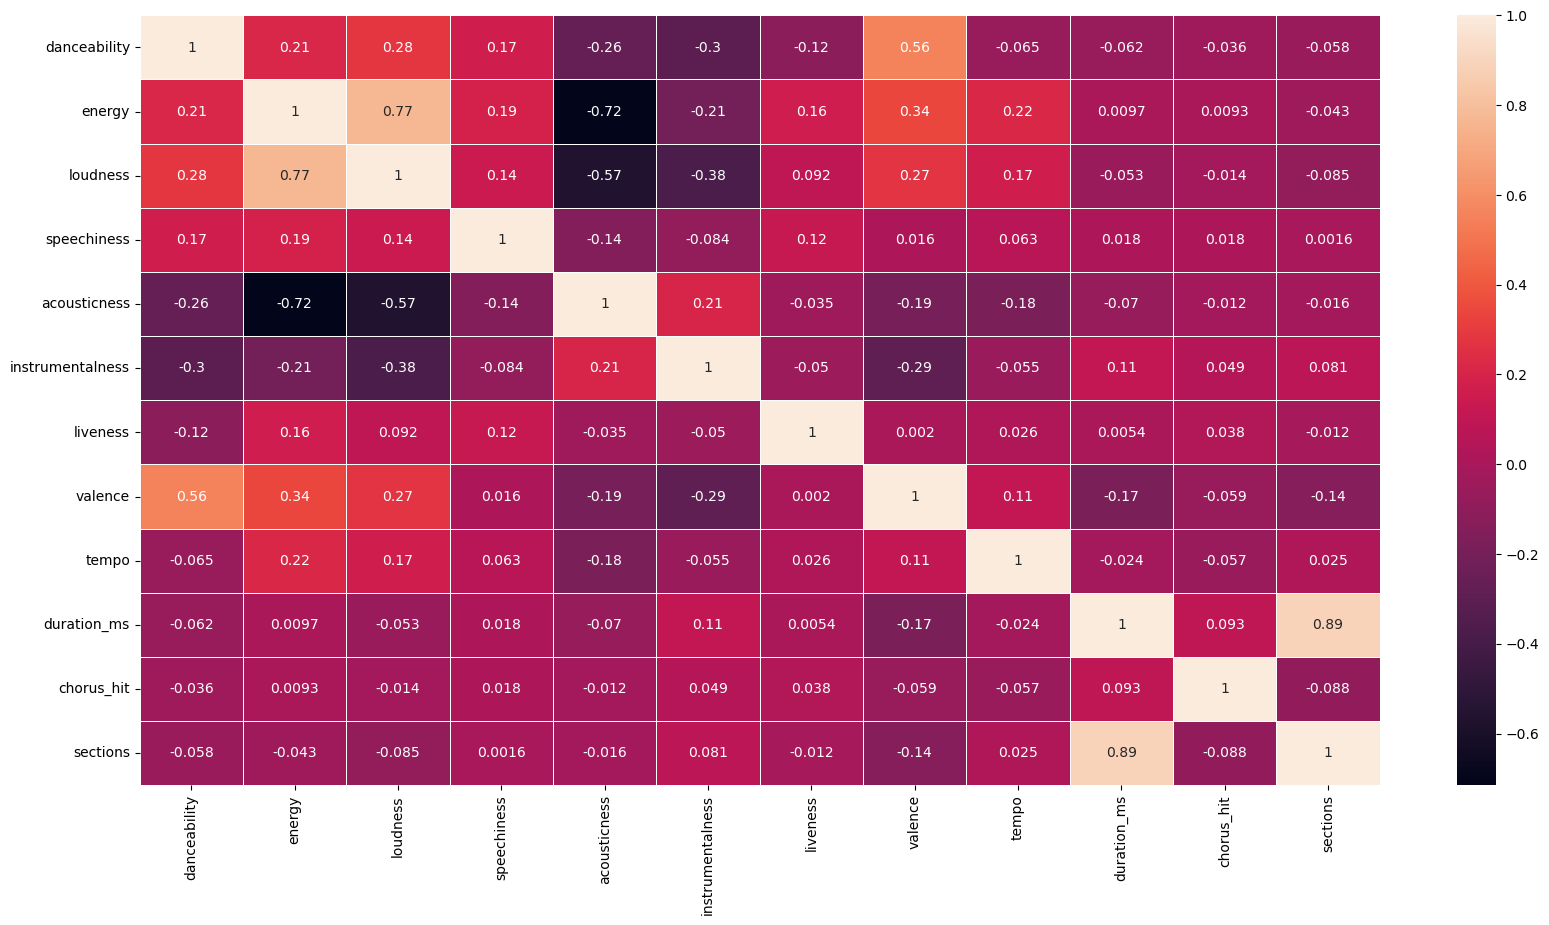

In [25]:
fig, ax = plt.subplots(figsize=(20,10))
dataplot = sns.heatmap(X_ohe[numerical_columns].corr(), annot=True, linewidths=0.5, ax=ax)

In [26]:
features_to_drop = ['sections','energy']
X_ohe.drop(columns=features_to_drop,inplace=True)
X_ohe

,mode,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,time_signature_5.0,decade_1960.0,decade_1970.0,decade_1980.0,decade_1990.0,decade_2000.0,decade_2010.0,artist_gender_Band,artist_gender_Female,artist_gender_Male
0,1.0,0.578,-7.270,0.0289,0.368000,0.000000,0.1590,0.532,133.061,196707.0,...,0,0,0,0,0,1,0,1,0,0
1,0.0,0.704,-5.477,0.1830,0.018500,0.000000,0.1480,0.688,92.988,242587.0,...,0,0,0,0,0,1,0,0,0,1
2,1.0,0.162,-3.009,0.0473,0.000111,0.004570,0.1740,0.300,86.964,338893.0,...,0,0,0,0,0,1,0,0,0,1
3,1.0,0.188,-3.745,0.1660,0.000007,0.078400,0.1920,0.333,148.440,255667.0,...,0,0,0,0,0,1,0,0,0,1
4,1.0,0.630,-4.353,0.0275,0.363000,0.000000,0.1250,0.631,112.098,193760.0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41101,0.0,0.396,-6.070,0.2340,0.000928,0.000209,0.1820,0.762,152.943,82107.0,...,0,0,0,0,1,0,0,1,0,0
41102,0.0,0.621,-6.281,0.0309,0.050600,0.006260,0.0937,0.690,134.167,211653.0,...,0,0,0,0,1,0,0,1,0,0
41103,0.0,0.562,-15.213,0.0298,0.440000,0.000011,0.1060,0.571,166.847,189827.0,...,0,0,0,0,1,0,0,1,0,0
41104,1.0,0.622,-6.080,0.0368,0.000101,0.755000,0.3830,0.214,120.051,330053.0,...,0,0,0,0,1,0,0,1,0,0


Update the numerical_columns list accordingly without the dropped features

In [27]:
numerical_columns = [col for col in numerical_columns if col not in features_to_drop]
numerical_columns

['danceability',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'chorus_hit']

Re-examine the feature to confirm that all high correlations have been eliminated

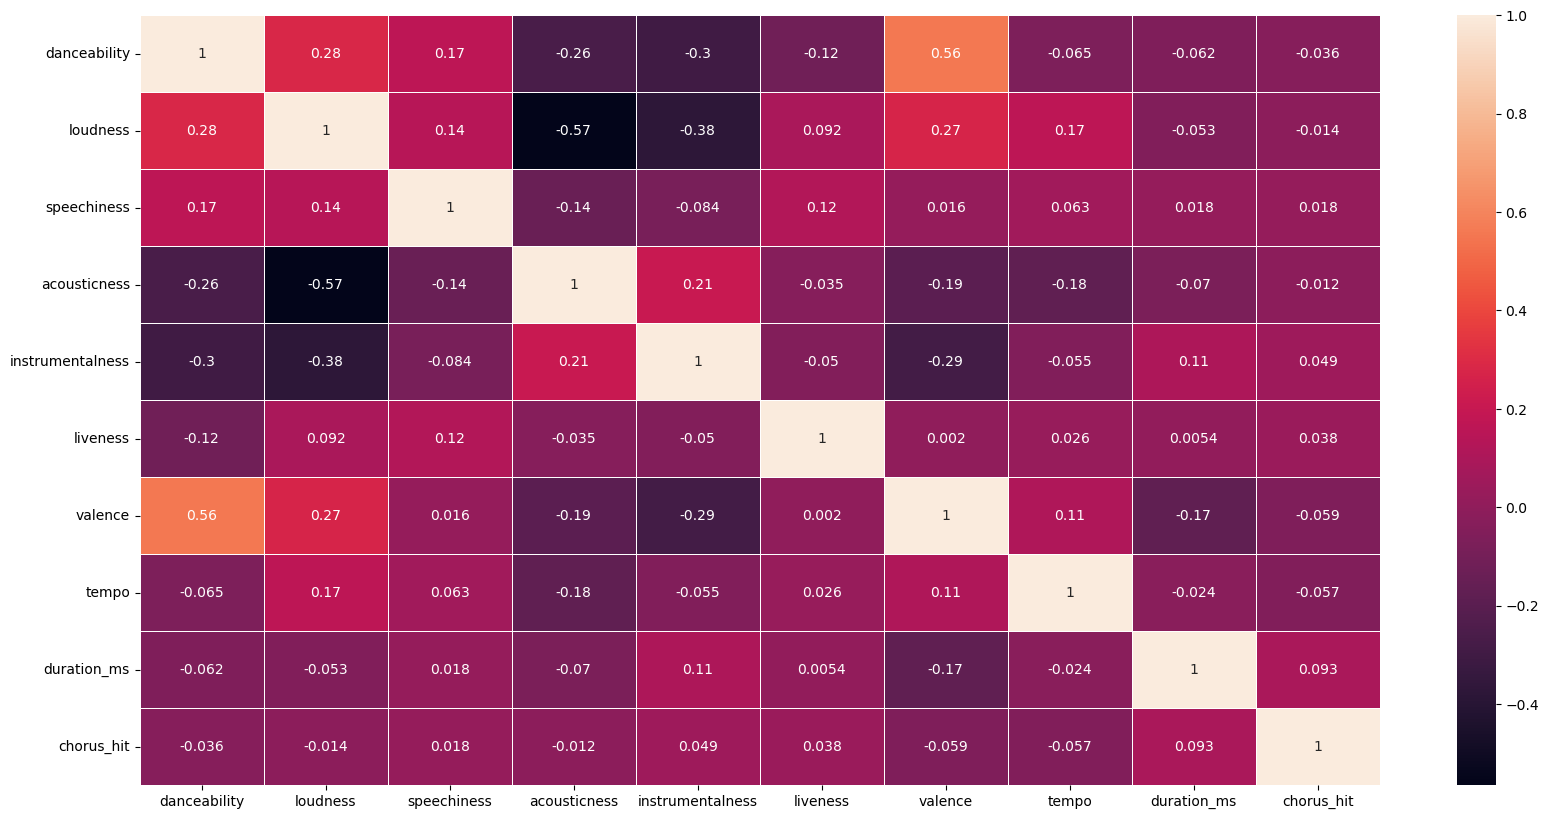

In [28]:
fig, ax = plt.subplots(figsize=(20,10))
dataplot = sns.heatmap(X_ohe[numerical_columns].corr(), annot=True, linewidths=0.5, ax=ax)

<br><b>Split Train-Test Data</b><br>
Since our dataset is large we can afford ourselves to use less than 20% of the data as test:

In [29]:
x_train_raw, x_test_raw, y_train, y_test = train_test_split(X_ohe,y, train_size = 0.85, random_state=0)
print(f"Train DataSet: {x_train_raw.shape[0]} with {x_train_raw.shape[1]} features")
print(f"Test DataSet: {x_test_raw.shape[0]} with {x_test_raw.shape[1]} features")

Train DataSet: 34820 with 38 features
Test DataSet: 6145 with 38 features


<br><b>Scaling</b><br>
We will fit the scale on the training dataset then use it to transform both train and test datasets.

In [30]:
# We will scale on the training dataset then apply it to both train and test
scalar = StandardScaler(copy=True, with_mean=True, with_std=True).fit(x_train_raw[numerical_columns])

train_scaled = pd.DataFrame(scalar.transform(x_train_raw[numerical_columns]),columns=numerical_columns)
test_scaled = pd.DataFrame(scalar.transform(x_test_raw[numerical_columns]),columns=numerical_columns)

x_train_scaled = x_train_raw.reset_index(drop=True)
x_test_scaled = x_test_raw.reset_index(drop=True)

for col in numerical_columns:
    x_train_scaled[col] = train_scaled[col].reset_index(drop=True)
    x_test_scaled[col] = test_scaled[col].reset_index(drop=True)
    
x_train_scaled.head(5).round(3)

,mode,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,time_signature_5.0,decade_1960.0,decade_1970.0,decade_1980.0,decade_1990.0,decade_2000.0,decade_2010.0,artist_gender_Band,artist_gender_Female,artist_gender_Male
0,0.0,0.660,0.671,-0.444,-0.056,-0.510,-0.449,-0.232,-0.670,-0.568,...,0,0,0,0,0,0,1,1,0,0
1,1.0,-0.949,0.543,-0.583,0.606,-0.510,-0.321,-1.025,0.447,-0.300,...,0,0,1,0,0,0,0,0,1,0
2,0.0,1.498,0.662,1.175,-0.932,-0.510,-0.672,1.125,-1.004,-0.187,...,0,0,0,0,1,0,0,1,0,0
3,1.0,-0.572,-1.459,-0.476,1.002,2.387,-0.711,0.415,1.008,0.806,...,0,0,1,0,0,0,0,0,0,1
4,1.0,-0.769,0.222,-0.378,-1.023,-0.510,0.491,-0.438,-0.203,-0.507,...,0,0,0,0,1,0,0,1,0,0


In [31]:
x_train_scaled.describe().round(3)

,mode,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,time_signature_5.0,decade_1960.0,decade_1970.0,decade_1980.0,decade_1990.0,decade_2000.0,decade_2010.0,artist_gender_Band,artist_gender_Female,artist_gender_Male
count,34820.000,34820.000,34820.000,34820.000,34820.000,34820.000,34820.000,34820.000,34820.000,34820.000,...,34820.000,34820.000,34820.000,34820.000,34820.000,34820.000,34820.000,34820.000,34820.000,34820.000
mean,0.693,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,...,0.014,0.209,0.190,0.168,0.135,0.142,0.157,0.333,0.139,0.527
std,0.461,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,0.116,0.406,0.392,0.374,0.341,0.349,0.363,0.471,0.346,0.499
min,0.000,-3.030,-7.381,-0.964,-1.070,-0.510,-1.089,-2.030,-4.103,-1.839,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,-0.673,-0.485,-0.502,-0.955,-0.510,-0.621,-0.797,-0.759,-0.518,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1.000,0.069,0.180,-0.369,-0.314,-0.510,-0.402,0.060,-0.062,-0.142,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
75%,1.000,0.727,0.723,-0.012,0.913,-0.303,0.346,0.845,0.591,0.268,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000
max,1.000,2.527,2.630,8.087,1.874,2.782,4.625,1.693,4.177,32.947,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


<br><br><br><b>Model Exploring</b><br>
In this section we will train and fine-turn various models to achieve the best prediction on our test dataset.

Please see a brief description of our work-plan:<br><br>
<b>Single Classifiers</b> - We will use a brute force method to train and fine tune 3 different Classifier types:
1. LogisticRegression
2. DecisionTreeClassifier
3. KNeighborsClassifier<br>

For each of these models, we wil try various hyper-parameter tunning and report the results.<br>

We will report the following:
* Trainning-Validation scores based on Cross-Validation
* Test scores based on test data prediction.
* AUC scores based on False-True/Negative-Positive ratios for each threshold and an ROC curve.<br>

We will then select our best performing model for feature importance, and attempt to improve its performence by removing features of low significance.

<b>Ensamle Models</b>:<br>
For this, we will split the training dataset into train80 and val.<br>
We will try and enhance the performence of a DecisionTreeClassifier model using the following bootstraping methods:<br>


<b>Boosting</b>
1. AdaBoostClassifier<br>

<b>Bagging:</b><br><br>
2. BaggingClassifier<br>
3. RandomForestClassifier<br>

We will report the following:
* Trainning scores based on train data pefromence.
* Validation scores based on validation dataset
* Test scores based on test data prediction.
* AUC scores based on False-True/Negative-Positive ration for each threshold and an ROC curve.<br>

We will then select our best performing method for feature importance, and attempt to improve its performence by removing features of low significance.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


List of models and hyper-parameters that we would like to examine:

In [33]:
dict_of_models = {'LogisticRegression':LogisticRegression(),
                  'DecisionTreeClassifier':DecisionTreeClassifier(), 
                 'KNeighborsClassifier':KNeighborsClassifier()
                 }


Since different models have different hyper-parameters, we have composed a list of all parameters across our models and the values for each hyper parameter we would like to explore.

In [34]:
parametersOfValue = {
    'n_neighbors':[2,4,8,15,50,80],
    'n_estimators':[50,100,500],
    'max_depth':[1,2,5,10,20,50],
    'learning_rate':[1,0.1,0.01,0.001,0.0001],
    'random_state':[1],
    'penalty':['l1','l2'],
    'solver':['saga'],
    'alpha':[1,0.1,0.01,0.001,0.0001],
    'C':[1,0.1,0.01,0.001,0.0001]
}

<br><b>Hyper Parameter Fuction:</b><br>
The function is meant to iterate over our list of models, match them with the hyper-parameters relevant to them and provide a row for each model-parameter-combination.:<br>

In [35]:
# get lists and output a dict of combinations:

def create_combination_dict(classifierName,parametersOfValue):
    prop_combinations = list(itertools.product(*(parametersOfValue[Name] for Name in parametersOfValue)))
    combinationsDict ={}
    for i,item in enumerate(prop_combinations):
        modelTempName = "%s_%s"%(classifierName,i)
        #print(modelTempName)
        combinationsDict[modelTempName]={'model_type':classifierName}
        for j,colName in enumerate(parametersOfValue.keys()):
            combinationsDict[modelTempName][colName]=item[j]
    
    
    return combinationsDict



### --------------------------------------------------------------------------------------------------------------------###
#Example run:

combinationsDict = create_combination_dict('TestClassifier',parametersOfValue)
combinationsDict = pd.DataFrame(combinationsDict).T
combinationsDict.head(3)

,model_type,n_neighbors,n_estimators,max_depth,learning_rate,random_state,penalty,solver,alpha,C
TestClassifier_0,TestClassifier,2,50,1,1,1,l1,saga,1,1
TestClassifier_1,TestClassifier,2,50,1,1,1,l1,saga,1,0.1
TestClassifier_2,TestClassifier,2,50,1,1,1,l1,saga,1,0.01


<br>The get_hyperparameter_combinations_per_classifier function receives a classifier and creates n rows of hyper-parameter combinations (Based on parametersOfValue list)

In [36]:
def get_hyperparameter_combinations_per_classifier(classifierName,classifierModel,parametersOfValue):

    # Extract the hyper-parameters from our selected model:
    paramList = classifierModel.get_params()

    classifierParametsOfValue = {}
    
    # Iterate over the parameters and match them to the parameter of value list:
    for param in paramList:
        if param in parametersOfValue.keys():
            classifierParametsOfValue[param]=parametersOfValue[param]

    # Convert list of hyper-parameters into a dictionary of parameter-combination
    combinationsDict_ForModel = create_combination_dict(classifierName,classifierParametsOfValue)

    relevantParametersForModel = combinationsDict_ForModel[list(combinationsDict_ForModel.keys())[0]].keys()
    print('Model Type: %s - %s hyper-parameter combinations'%(classifierName,len(combinationsDict_ForModel)))
    
    return combinationsDict_ForModel


### --------------------------------------------------------------------------------------------------------------------###
#Example run:


classifierName,classifierModel = ('LogisticRegression',LogisticRegression())
combinationsDict_ForModel = get_hyperparameter_combinations_per_classifier(classifierName,classifierModel,parametersOfValue=parametersOfValue)
#pd.DataFrame(combinationsDict_ForModel).T.head(10)

Model Type: LogisticRegression - 10 hyper-parameter combinations


<br>We then over our list of model, and for each model retrieve a list of all available hyper-parameter combinations and append them to dictionary

In [37]:
all_model_combinations = {}

for classifierName,classifierModel in dict_of_models.items():
    #print(classifierName,classifierModel)
    combinationsDict_ForModel = get_hyperparameter_combinations_per_classifier(classifierName,classifierModel,parametersOfValue=parametersOfValue)
    #print(combinationsDict_ForModel)
    all_model_combinations.update(combinationsDict_ForModel)

all_model_combinations_df = pd.DataFrame(all_model_combinations).T

Model Type: LogisticRegression - 10 hyper-parameter combinations
Model Type: DecisionTreeClassifier - 6 hyper-parameter combinations
Model Type: KNeighborsClassifier - 6 hyper-parameter combinations


<br>Our final result is a data frame containing all the model types and their hyper-parameters that we will use in our test.

In [38]:
print(f'There are {all_model_combinations_df.shape[0]} different model combinations for us to test')
all_model_combinations_df

There are 22 different model combinations for us to test


,model_type,C,penalty,random_state,solver,max_depth,n_neighbors
LogisticRegression_0,LogisticRegression,1,l1,1,saga,NaN,NaN
LogisticRegression_1,LogisticRegression,1,l2,1,saga,NaN,NaN
LogisticRegression_2,LogisticRegression,0.1,l1,1,saga,NaN,NaN
LogisticRegression_3,LogisticRegression,0.1,l2,1,saga,NaN,NaN
LogisticRegression_4,LogisticRegression,0.01,l1,1,saga,NaN,NaN
LogisticRegression_5,LogisticRegression,0.01,l2,1,saga,NaN,NaN
LogisticRegression_6,LogisticRegression,0.001,l1,1,saga,NaN,NaN
LogisticRegression_7,LogisticRegression,0.001,l2,1,saga,NaN,NaN
LogisticRegression_8,LogisticRegression,0.0001,l1,1,saga,NaN,NaN
LogisticRegression_9,LogisticRegression,0.0001,l2,1,saga,NaN,NaN


<br><b>Brute strength testing:</b><br><br>
Using the all_model_combinations_df we created, we can now iterate over our model instructions, and for each row:<br>
1. Update the model hyper-parameters based on the row instructions.
2. cross_validate the model and save the train/val scores to the data frame.
3. Fit the model on the entire train dataset.
4. Test the model using test data and save the test score to the data frame.
5. Use predict_proba method in the test and use these y probabilities to get our auc_result (** We will expand in it later in this notebook)
6. Save the AUC score to the data frame.

Additional outputs we will write to the data frame:
* Train/Test size
* Feature number
* Run time (In seconds)


In [39]:
dict_of_fitted_models = {}

for i,model_row in enumerate(all_model_combinations_df.T.items()):
    
    start = timer()
    
    # Take existing model and set it hyper parameters based on instructions:
    model_name = model_row[0]
    model_type = model_row[1][0]
    classifierModel = clone(dict_of_models[model_type])
    model_props = classifierModel.get_params()
    
    model_properties_instructions = model_row[1][1:]
     
    
    for prop_instruction in model_properties_instructions.index:
        if (prop_instruction in list(model_props.keys())):
            model_props[prop_instruction]=model_properties_instructions[prop_instruction]
            
    classifierModel.set_params(**model_props)
    
    #print(f"Model Name: {model_name} - {classifierModel}")
    
    cross_val = cross_validate(classifierModel, x_train_scaled, y_train, cv=3, scoring='accuracy', return_train_score=True)
    
    train_score = np.mean(cross_val['train_score'])
    val_score = np.mean(cross_val['test_score'])    
    
    # Fit on entire training data
    classifierModel.fit(x_train_scaled, y_train)
    test_score = classifierModel.score(x_test_scaled,y_test)
    
    all_model_combinations_df.at[model_name,'train_score']=train_score
    all_model_combinations_df.at[model_name,'val_score']=val_score
    all_model_combinations_df.at[model_name,'test_score']=test_score
    
    yhat= classifierModel.predict_proba(x_test_scaled)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, yhat)
    auc_result = auc(fpr,tpr)
    all_model_combinations_df.at[model_name,'auc_result']=auc_result
    
    
    all_model_combinations_df.at[model_name,'train_size']=x_train_scaled.shape[0]
    all_model_combinations_df.at[model_name,'test_size']=x_test_scaled.shape[0]
    all_model_combinations_df.at[model_name,'feature_n']=x_test_scaled.shape[1]
        
    
    end = timer()
    run_time_secs = round(end - start,4)
    all_model_combinations_df.at[model_name,'run_time']=run_time_secs
    
    all_model_combinations_df.at[model_name,'trained_model']=classifierModel
    dict_of_fitted_models[model_name] = classifierModel
    
    print(f"Model Name: {model_name} - {classifierModel} - val_score: {round(val_score,3)}.")

    #model_row['traingSize']=x_train_scaled.shape[0]
    #model_row['test_size']=x_test_scaled.shape[0]
    
    
print("Finished Run")

Model Name: LogisticRegression_0 - LogisticRegression(C=1, penalty='l1', random_state=1, solver='saga') - val_score: 0.755.
Model Name: LogisticRegression_1 - LogisticRegression(C=1, random_state=1, solver='saga') - val_score: 0.755.
Model Name: LogisticRegression_2 - LogisticRegression(C=0.1, penalty='l1', random_state=1, solver='saga') - val_score: 0.755.
Model Name: LogisticRegression_3 - LogisticRegression(C=0.1, random_state=1, solver='saga') - val_score: 0.755.
Model Name: LogisticRegression_4 - LogisticRegression(C=0.01, penalty='l1', random_state=1, solver='saga') - val_score: 0.752.
Model Name: LogisticRegression_5 - LogisticRegression(C=0.01, random_state=1, solver='saga') - val_score: 0.753.
Model Name: LogisticRegression_6 - LogisticRegression(C=0.001, penalty='l1', random_state=1, solver='saga') - val_score: 0.71.
Model Name: LogisticRegression_7 - LogisticRegression(C=0.001, random_state=1, solver='saga') - val_score: 0.738.
Model Name: LogisticRegression_8 - LogisticRegr

<br>Finally, we will have a data frame containning our models, their instructions, and their resaults:

In [40]:
print(f"All model and their scores sorted by name")
all_model_combinations_df

All model and their scores sorted by name


,model_type,C,penalty,random_state,solver,max_depth,n_neighbors,train_score,val_score,test_score,auc_result,train_size,test_size,feature_n,run_time,trained_model
LogisticRegression_0,LogisticRegression,1,l1,1,saga,NaN,NaN,0.757539,0.755428,0.754760,0.829820,34820.0,6145.0,38.0,7.2369,"LogisticRegression(C=1, penalty='l1', random_s..."
LogisticRegression_1,LogisticRegression,1,l2,1,saga,NaN,NaN,0.757453,0.755457,0.754760,0.829807,34820.0,6145.0,38.0,5.8927,"LogisticRegression(C=1, random_state=1, solver..."
LogisticRegression_2,LogisticRegression,0.1,l1,1,saga,NaN,NaN,0.757108,0.754710,0.754434,0.829817,34820.0,6145.0,38.0,5.6404,"LogisticRegression(C=0.1, penalty='l1', random..."
LogisticRegression_3,LogisticRegression,0.1,l2,1,saga,NaN,NaN,0.757237,0.754825,0.754272,0.829808,34820.0,6145.0,38.0,5.9127,"LogisticRegression(C=0.1, random_state=1, solv..."
LogisticRegression_4,LogisticRegression,0.01,l1,1,saga,NaN,NaN,0.752829,0.752412,0.754272,0.827472,34820.0,6145.0,38.0,1.5584,"LogisticRegression(C=0.01, penalty='l1', rando..."
LogisticRegression_5,LogisticRegression,0.01,l2,1,saga,NaN,NaN,0.755356,0.753418,0.753133,0.829323,34820.0,6145.0,38.0,3.0838,"LogisticRegression(C=0.01, random_state=1, sol..."
LogisticRegression_6,LogisticRegression,0.001,l1,1,saga,NaN,NaN,0.710569,0.709908,0.714239,0.787602,34820.0,6145.0,38.0,1.1141,"LogisticRegression(C=0.001, penalty='l1', rand..."
LogisticRegression_7,LogisticRegression,0.001,l2,1,saga,NaN,NaN,0.738685,0.737507,0.738161,0.818613,34820.0,6145.0,38.0,0.9482,"LogisticRegression(C=0.001, random_state=1, so..."
LogisticRegression_8,LogisticRegression,0.0001,l1,1,saga,NaN,NaN,0.500230,0.500230,0.508544,0.500000,34820.0,6145.0,38.0,0.3915,"LogisticRegression(C=0.0001, penalty='l1', ran..."
LogisticRegression_9,LogisticRegression,0.0001,l2,1,saga,NaN,NaN,0.716083,0.716054,0.713914,0.793352,34820.0,6145.0,38.0,0.9277,"LogisticRegression(C=0.0001, random_state=1, s..."


<br><b>Best Performing model:</b><br>
Since we collected all sort of output scores from our model, we can check and see which model performed best for each category:

"Show off" award:<br>
The award for the model with the best training score:

In [41]:
cols_to_show = ['model_type','C','penalty','solver','max_depth','n_neighbors','train_score','val_score','test_score','auc_result','run_time']
print(f"Top 3 performing models based on Validation Score")
all_model_combinations_df[cols_to_show].sort_values(by='val_score', ascending=False).head(3)

Top 3 performing models based on Validation Score


,model_type,C,penalty,solver,max_depth,n_neighbors,train_score,val_score,test_score,auc_result,run_time
DecisionTreeClassifier_3,DecisionTreeClassifier,NaN,NaN,NaN,10,NaN,0.833099,0.769271,0.772986,0.826306,1.1701
KNeighborsClassifier_3,KNeighborsClassifier,NaN,NaN,NaN,NaN,15,0.791427,0.765968,0.768592,0.854944,7.3001
KNeighborsClassifier_2,KNeighborsClassifier,NaN,NaN,NaN,NaN,8,0.821080,0.765020,0.773963,0.842545,7.1287


Accuracy award:<br>
The award for best overall test score model (Based on proportion of correct predictions made by the classifier)

In [42]:

print(f"Top 3 performing models based on Test Score")
all_model_combinations_df[cols_to_show].sort_values(by='test_score', ascending=False).head(3)

Top 3 performing models based on Test Score


,model_type,C,penalty,solver,max_depth,n_neighbors,train_score,val_score,test_score,auc_result,run_time
KNeighborsClassifier_2,KNeighborsClassifier,NaN,NaN,NaN,NaN,8,0.821080,0.765020,0.773963,0.842545,7.1287
DecisionTreeClassifier_3,DecisionTreeClassifier,NaN,NaN,NaN,10,NaN,0.833099,0.769271,0.772986,0.826306,1.1701
KNeighborsClassifier_4,KNeighborsClassifier,NaN,NaN,NaN,NaN,50,0.769802,0.761114,0.769731,0.863065,8.1253


AUC award:<br>
The award for the model best able to distinguish between the two classes by plotting the true positive rate (TPR) against the false positive rate (FPR) at different classification thresholds and calculating the area under their curve

In [43]:

print(f"Top 3 performing models based on AUC Score")
all_model_combinations_df[cols_to_show].sort_values(by='auc_result', ascending=False).head(3)

Top 3 performing models based on AUC Score


,model_type,C,penalty,solver,max_depth,n_neighbors,train_score,val_score,test_score,auc_result,run_time
KNeighborsClassifier_4,KNeighborsClassifier,NaN,NaN,NaN,NaN,50,0.769802,0.761114,0.769731,0.863065,8.1253
KNeighborsClassifier_5,KNeighborsClassifier,NaN,NaN,NaN,NaN,80,0.759994,0.754739,0.765663,0.861220,8.6731
KNeighborsClassifier_3,KNeighborsClassifier,NaN,NaN,NaN,NaN,15,0.791427,0.765968,0.768592,0.854944,7.3001


<br><b>ROC Curve:</b><br>
We will now plot the ratio between true positive rate (TPR) against the false positive rate (FPR) at different classification thresholds for the best performing model of each classifier type.

In [44]:
def plot_roc_curve(model,X,Y, model_name="Classification Model"):
    
    # Plot the ROC curve
    yhat= model.predict_proba(X)[:,1]

    fpr, tpr, thresholds = roc_curve(Y, yhat)
    auc_result = auc(fpr,tpr)

    x=np.arange(0,100)/100
    ax.plot(x,x,'--',color="gray",alpha=0.3)
    ax.plot(fpr,tpr,label=model_name)
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    ax.set_title(f"ROC Curve for top performing models.")
    ax.legend()
    ax.plot()

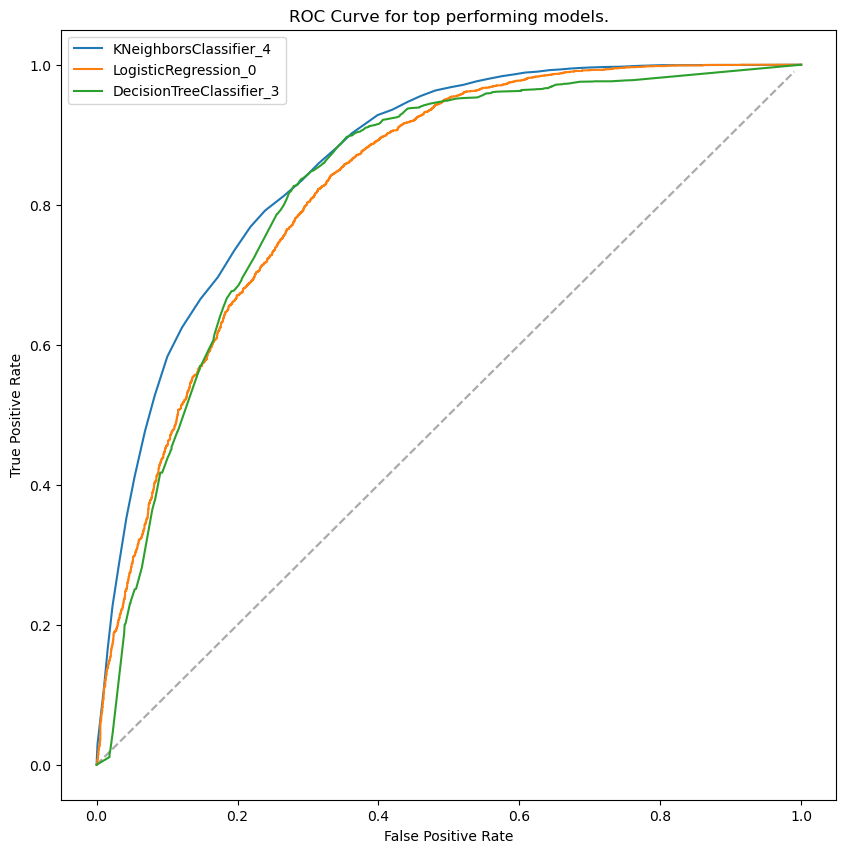

In [45]:
list_of_unique_model_types = list(dict_of_models.keys())
col_size = 2

fig, ax = plt.subplots(1,1, figsize=(10,10))

for i, item in enumerate(all_model_combinations_df.sort_values(by='auc_result', ascending=False).T.items()):
    model_name = item[0]
    model_record = item[1]
    model_type = model_record['model_type']
    
    if model_type in list_of_unique_model_types:
        trained_model = model_record['trained_model'].fit(x_train_scaled,y_train)
    
        plot_roc_curve(trained_model,x_test_scaled,y_test,model_name=model_name)
        
        list_of_unique_model_types.remove(model_type)
    

In [46]:
best_performing_model = all_model_combinations_df.sort_values(by='auc_result', ascending=False).head(1)
best_model = best_performing_model['trained_model'][0].fit(x_train_scaled,y_train)
print(f"Our best performing model so far is {best_model} --> {round(best_performing_model['auc_result'][0],3)} AUC score")

Our best performing model so far is KNeighborsClassifier(n_neighbors=50) --> 0.863 AUC score


<br><b>Confusion Matrix:</b><br>
We will observe our predictions and try and see how the model preforms on each of the classes:

In [47]:
predicted_labels  = best_model.predict(x_test_scaled)
confusion_mat = confusion_matrix(y_test, predicted_labels)

# print the confusion matrix
pd.DataFrame(confusion_mat,columns=["P.Flop","P.Hit"],index=["Flop","Hit"])

,P.Flop,P.Hit
Flop,1870,1150
Hit,265,2860


In [48]:
y_test.value_counts()

1    3125
0    3020
dtype: int64

<br><b>Feature importance:</b><br>
Since KNeighborsClassifier doesn't provide a clear way to calculate feature importance, we will go to the 2nd best modele which isn't KNeighborsClassifier to get this information from

In [49]:
second_best_performing_model = all_model_combinations_df[all_model_combinations_df['model_type']=="DecisionTreeClassifier"].sort_values(by='auc_result', ascending=False).head(1)
second_best_model = second_best_performing_model['trained_model'][0].fit(x_train_scaled,y_train)
print(f"Our best performing model so far is {second_best_model} --> {round(second_best_performing_model['auc_result'][0],3)} AUC score")

Our best performing model so far is DecisionTreeClassifier(max_depth=10, random_state=1) --> 0.826 AUC score


In [50]:
x_df = x_train_scaled.copy()
x_df = x_df.reset_index()
_y_train = y_train.reset_index(drop=True)
x_df['y'] = _y_train
model = clone(second_best_model)

n = x_df.shape[0]
result_list = []
coef_list = {col:[] for col in x_train_scaled.columns}

bar = progressbar.ProgressBar(maxval=100, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for i in range(100):
    #Take a random sample from the df:
    x_df_sample = x_df.sample(n=n,replace=True)
    
    # Split the df into x and y
    y_ = x_df_sample['y']
    x_ = x_df_sample.copy().drop('y', axis=1)
    
    # Initialize a Linear Regression object with fit_intercept as False
    
    
    model.fit(x_,y_)
    
    # Extract the coefficients from the trained model and store them in a list
    coefficients = model.feature_importances_
    
    for n,coef_name in enumerate(x_train_scaled.columns):
        coef_value = coefficients[n]
        coef_list[coef_name].append(coef_value)
        
    bar.update(i)
        
coef_df = pd.DataFrame(coef_list)

In [51]:
coef_df = pd.DataFrame(coef_list)
coef_df.head(10)

,mode,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,time_signature_5.0,decade_1960.0,decade_1970.0,decade_1980.0,decade_1990.0,decade_2000.0,decade_2010.0,artist_gender_Band,artist_gender_Female,artist_gender_Male
0,0.013287,0.009179,0.108628,0.027114,0.051057,0.143082,0.379642,0.010504,0.032481,0.020191,...,0.001569,0.0,0.015245,0.007328,0.000661,0.007171,0.000575,0.008562,0.000107,0.004709
1,0.000000,0.000000,0.240339,0.000000,0.000000,0.082428,0.324152,0.000000,0.092126,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.260567,0.000000,0.274083,0.000000,0.130588,0.101569,0.065294,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.069958,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.183198,0.000000,0.000000,0.000000,0.237294,0.000000,0.282187,0.166555,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.124194,0.169898,0.083459,0.096354,0.315914,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.193697,0.170959,0.000000,0.000000,0.000000,0.000000,0.056733,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.092500,0.000000
6,0.167877,0.000000,0.000000,0.000000,0.000000,0.231830,0.054094,0.081960,0.291188,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.123642,0.000000,0.309533,0.082589,0.000000,0.000000,0.000000,0.094388,0.082589,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.204301,0.164759,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.113339,0.000000,0.000000,0.227193,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.099865,0.000000,0.224003,0.000000,0.129825,0.086550,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [52]:
coef_df.mean().sort_values(ascending=False).round(4)

liveness                0.2035
loudness                0.1077
instrumentalness        0.0914
speechiness             0.0734
valence                 0.0703
acousticness            0.0684
chorus_hit              0.0574
tempo                   0.0559
mode                    0.0493
duration_ms             0.0485
is_missing_gender       0.0348
key_0.0                 0.0153
key_3.0                 0.0112
decade_1980.0           0.0107
key_8.0                 0.0082
key_5.0                 0.0074
artist_gender_Male      0.0072
danceability            0.0068
key_1.0                 0.0060
artist_gender_Female    0.0056
artist_gender_Band      0.0055
decade_2000.0           0.0048
key_7.0                 0.0046
key_2.0                 0.0045
decade_1970.0           0.0044
key_10.0                0.0044
time_signature_0.0      0.0040
time_signature_5.0      0.0031
decade_2010.0           0.0028
key_11.0                0.0025
decade_1990.0           0.0025
key_9.0                 0.0024
key_4.0 

In [53]:
# Create a dict for each coef containnig the 95% confidence interval
threshold_for_feature_importance = 0.1
coef_info = {}

features_to_keep = []

for feature, coef in coef_df.items():
    conf_int = np.percentile(coef,[2.5,97.5])
    coef_info[feature]=conf_int
    
    min_precentile = conf_int[0]
    max_precentile = conf_int[1]
    
    if max_precentile >= threshold_for_feature_importance: 
        features_to_keep.append(feature)
        print(f"For coef {feature} the low 5% is {round(min_precentile,3)} and the high 95% is {round(max_precentile,3)}")
    else:
        print(f"For coef {feature} the low 5% is {round(min_precentile,3)} and the high 95% is {round(max_precentile,3)} - Dropping feature.")
    
    
    

For coef mode the low 5% is 0.0 and the high 95% is 0.261
For coef danceability the low 5% is 0.0 and the high 95% is 0.097 - Dropping feature.
For coef loudness the low 5% is 0.0 and the high 95% is 0.481
For coef speechiness the low 5% is 0.0 and the high 95% is 0.374
For coef acousticness the low 5% is 0.0 and the high 95% is 0.326
For coef instrumentalness the low 5% is 0.0 and the high 95% is 0.402
For coef liveness the low 5% is 0.0 and the high 95% is 0.55
For coef valence the low 5% is 0.0 and the high 95% is 0.284
For coef tempo the low 5% is 0.0 and the high 95% is 0.305
For coef duration_ms the low 5% is 0.0 and the high 95% is 0.276
For coef chorus_hit the low 5% is 0.0 and the high 95% is 0.36
For coef is_missing_gender the low 5% is 0.0 and the high 95% is 0.292
For coef key_0.0 the low 5% is 0.0 and the high 95% is 0.174
For coef key_1.0 the low 5% is 0.0 and the high 95% is 0.083 - Dropping feature.
For coef key_2.0 the low 5% is 0.0 and the high 95% is 0.091 - Dropping

In [54]:
print(f"{len(features_to_keep)} features to keep: \n{features_to_keep}")

19 features to keep: 
['mode', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'chorus_hit', 'is_missing_gender', 'key_0.0', 'key_3.0', 'key_5.0', 'key_8.0', 'decade_1980.0', 'artist_gender_Band', 'artist_gender_Female', 'artist_gender_Male']


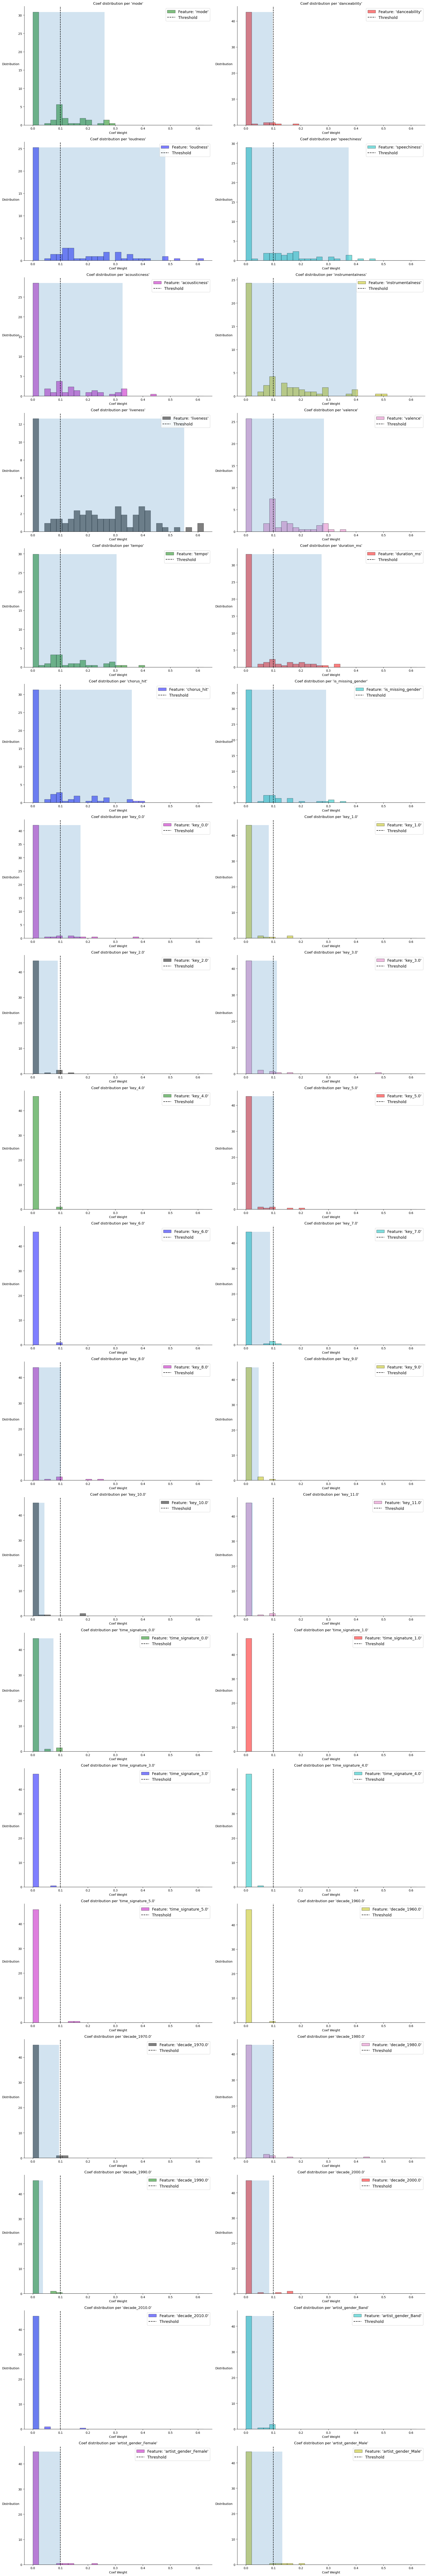

In [55]:
# Plot all the coefficients histogram seperatly



coeff_num = coef_df.shape[1]
row_num = math.ceil(coeff_num/2)
bin_start = min(coef_df.min())
bin_end = max(coef_df.max())

fig = plt.gcf()
fig.set_size_inches(20,120)
bins = np.linspace(bin_start, bin_end, 30)
c_list = ['g','r','b','c','m','y','k','tab:pink','g','r','b','c','m','y','k','tab:pink','g','r','b','c','m','y','k','tab:pink','g','r','b','c','m','y','k','tab:pink','g','r','b','c','m','y','k','tab:pink']


for i,(coef,values) in enumerate(coef_df.items()):
    
    ax = fig.add_subplot(row_num,2,i+1)
    
    height, bins, patches = ax.hist(values, bins, alpha=0.5, label=f"Feature: '{coef}'",density=True,edgecolor='k', color=c_list[i])
    
    ax.fill_betweenx([0, height.max()], coef_info[coef][0], coef_info[coef][1], alpha=0.2)
    ax.axline((threshold_for_feature_importance, 0), 
              (threshold_for_feature_importance, 1), 
              linestyle='dashed',
              slope=None, color='black', label='Threshold')
    
    ax.legend(loc='upper right',fontsize=13)
    ax.set_xlabel('Coef Weight')
    ax.set_ylabel('Distribution',rotation=0,labelpad=25)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(f"Coef distribution per '{coef}'")
    i+=1

plt.tight_layout()
plt.plot;

<br>We will now attempt to re-train the same model on the significant features only

In [56]:
print(f"Features to keep: {features_to_keep}")

Features to keep: ['mode', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'chorus_hit', 'is_missing_gender', 'key_0.0', 'key_3.0', 'key_5.0', 'key_8.0', 'decade_1980.0', 'artist_gender_Band', 'artist_gender_Female', 'artist_gender_Male']


In [57]:
model_name = 'DecisionTreeClassifier_3_thin'
classifierModel = clone(second_best_model)

start = timer()

cross_val = cross_validate(classifierModel, x_train_scaled[features_to_keep], y_train, cv=3, scoring='accuracy', return_train_score=True)
    
train_score = np.mean(cross_val['train_score'])
val_score = np.mean(cross_val['test_score'])    

# Fit on entire training data
classifierModel.fit(x_train_scaled[features_to_keep], y_train)
test_score = classifierModel.score(x_test_scaled[features_to_keep],y_test)

all_model_combinations_df.at[model_name,'train_score']=train_score
all_model_combinations_df.at[model_name,'val_score']=val_score
all_model_combinations_df.at[model_name,'test_score']=test_score

yhat= classifierModel.predict_proba(x_test_scaled[features_to_keep])[:,1]

fpr, tpr, thresholds = roc_curve(y_test, yhat)
auc_result = auc(fpr,tpr)
all_model_combinations_df.at[model_name,'auc_result']=auc_result


all_model_combinations_df.at[model_name,'train_size']=x_train_scaled.shape[0]
all_model_combinations_df.at[model_name,'test_size']=x_test_scaled.shape[0]
all_model_combinations_df.at[model_name,'feature_n']=x_test_scaled.shape[1]

all_model_combinations_df.at[model_name,'trained_model']=classifierModel

end = timer()
run_time_secs = round(end - start,4)
all_model_combinations_df.at[model_name,'run_time']=run_time_secs

all_model_combinations_df.at[model_name,'trained_model']=classifierModel

print(f"{model_name} - Val: {round(val_score,3)}, Test: {round(test_score,3)}, AUC: {round(auc_result,3)}")

DecisionTreeClassifier_3_thin - Val: 0.761, Test: 0.761, AUC: 0.805


<br>Let us also check how much this improved our KNeighborsClassifier:

In [58]:
model_name = 'KNeighborsClassifier_5_thin'
classifierModel = clone(best_model)

start = timer()

cross_val = cross_validate(classifierModel, x_train_scaled[features_to_keep], y_train, cv=3, scoring='accuracy', return_train_score=True)
    
train_score = np.mean(cross_val['train_score'])
val_score = np.mean(cross_val['test_score'])    

# Fit on entire training data
classifierModel.fit(x_train_scaled[features_to_keep], y_train)
test_score = classifierModel.score(x_test_scaled[features_to_keep],y_test)

all_model_combinations_df.at[model_name,'train_score']=train_score
all_model_combinations_df.at[model_name,'val_score']=val_score
all_model_combinations_df.at[model_name,'test_score']=test_score

yhat= classifierModel.predict_proba(x_test_scaled[features_to_keep])[:,1]

fpr, tpr, thresholds = roc_curve(y_test, yhat)
auc_result = auc(fpr,tpr)
all_model_combinations_df.at[model_name,'auc_result']=auc_result


all_model_combinations_df.at[model_name,'train_size']=x_train_scaled[features_to_keep].shape[0]
all_model_combinations_df.at[model_name,'test_size']=x_test_scaled[features_to_keep].shape[0]
all_model_combinations_df.at[model_name,'feature_n']=x_test_scaled[features_to_keep].shape[1]


all_model_combinations_df.at[model_name,'trained_model']=classifierModel


end = timer()
run_time_secs = round(end - start,4)
all_model_combinations_df.at[model_name,'run_time']=run_time_secs

all_model_combinations_df.at[model_name,'trained_model']=classifierModel

print(f"{model_name} - Val: {round(val_score,3)}, Test: {round(test_score,3)}, AUC: {round(auc_result,3)}")

KNeighborsClassifier_5_thin - Val: 0.743, Test: 0.751, AUC: 0.837


In [59]:
all_model_combinations_df.sort_values(by='auc_result', ascending=False).head(10)

,model_type,C,penalty,random_state,solver,max_depth,n_neighbors,train_score,val_score,test_score,auc_result,train_size,test_size,feature_n,run_time,trained_model
KNeighborsClassifier_4,KNeighborsClassifier,NaN,NaN,NaN,NaN,NaN,50,0.769802,0.761114,0.769731,0.863065,34820.0,6145.0,38.0,8.1253,KNeighborsClassifier(n_neighbors=50)
KNeighborsClassifier_5,KNeighborsClassifier,NaN,NaN,NaN,NaN,NaN,80,0.759994,0.754739,0.765663,0.861220,34820.0,6145.0,38.0,8.6731,KNeighborsClassifier(n_neighbors=80)
KNeighborsClassifier_3,KNeighborsClassifier,NaN,NaN,NaN,NaN,NaN,15,0.791427,0.765968,0.768592,0.854944,34820.0,6145.0,38.0,7.3001,KNeighborsClassifier(n_neighbors=15)
KNeighborsClassifier_2,KNeighborsClassifier,NaN,NaN,NaN,NaN,NaN,8,0.821080,0.765020,0.773963,0.842545,34820.0,6145.0,38.0,7.1287,KNeighborsClassifier(n_neighbors=8)
KNeighborsClassifier_5_thin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.752886,0.742964,0.750529,0.837247,34820.0,6145.0,19.0,7.1188,KNeighborsClassifier(n_neighbors=50)
LogisticRegression_0,LogisticRegression,1,l1,1,saga,NaN,NaN,0.757539,0.755428,0.754760,0.829820,34820.0,6145.0,38.0,7.2369,"LogisticRegression(C=1, penalty='l1', random_s..."
LogisticRegression_2,LogisticRegression,0.1,l1,1,saga,NaN,NaN,0.757108,0.754710,0.754434,0.829817,34820.0,6145.0,38.0,5.6404,"LogisticRegression(C=0.1, penalty='l1', random..."
LogisticRegression_3,LogisticRegression,0.1,l2,1,saga,NaN,NaN,0.757237,0.754825,0.754272,0.829808,34820.0,6145.0,38.0,5.9127,"LogisticRegression(C=0.1, random_state=1, solv..."
LogisticRegression_1,LogisticRegression,1,l2,1,saga,NaN,NaN,0.757453,0.755457,0.754760,0.829807,34820.0,6145.0,38.0,5.8927,"LogisticRegression(C=1, random_state=1, solver..."
LogisticRegression_5,LogisticRegression,0.01,l2,1,saga,NaN,NaN,0.755356,0.753418,0.753133,0.829323,34820.0,6145.0,38.0,3.0838,"LogisticRegression(C=0.01, random_state=1, sol..."


<br><b>Ensemble Models:</b><br>
Ensemble models are machine learning algorithms that combine the predictions of multiple base models to make more accurate predictions.

In [60]:
# Make a dict to store fitted models and the features we used:
ensemble_model_list = []

Unlike Single Classification models where we used cross-val on our training set, for Bootstrapping methods we will need to create a separate validation data-set

In [61]:
random_state=1
X_train80, X_val, y_train80, y_val = train_test_split(x_train_scaled,
                                                      y_train,
                                                      train_size=.8,
                                                      random_state=random_state,
                                                      stratify=y_train)

<br><b>Boosting:</b><br>
AdaBoostClassifier is an adaptive boosting algorithm, which means that it trains the base models sequentially, with each model focusing on the examples that were misclassified by the previous model. This allows the base models to learn from each other and improve the performance of the overall model. 

Since the computational power of these models is expansive, we have already fine tuned the hyper-parameters in advance and found that the models perform best with the following settings: 

New best score was found of 0.7743 High was found for Dept: 1, best_n_estimators: 499
New best score was found of 0.8046 High was found for Dept: 3, best_n_estimators: 462
New best score was found of 0.807 High was found for Dept: 5, best_n_estimators: 259


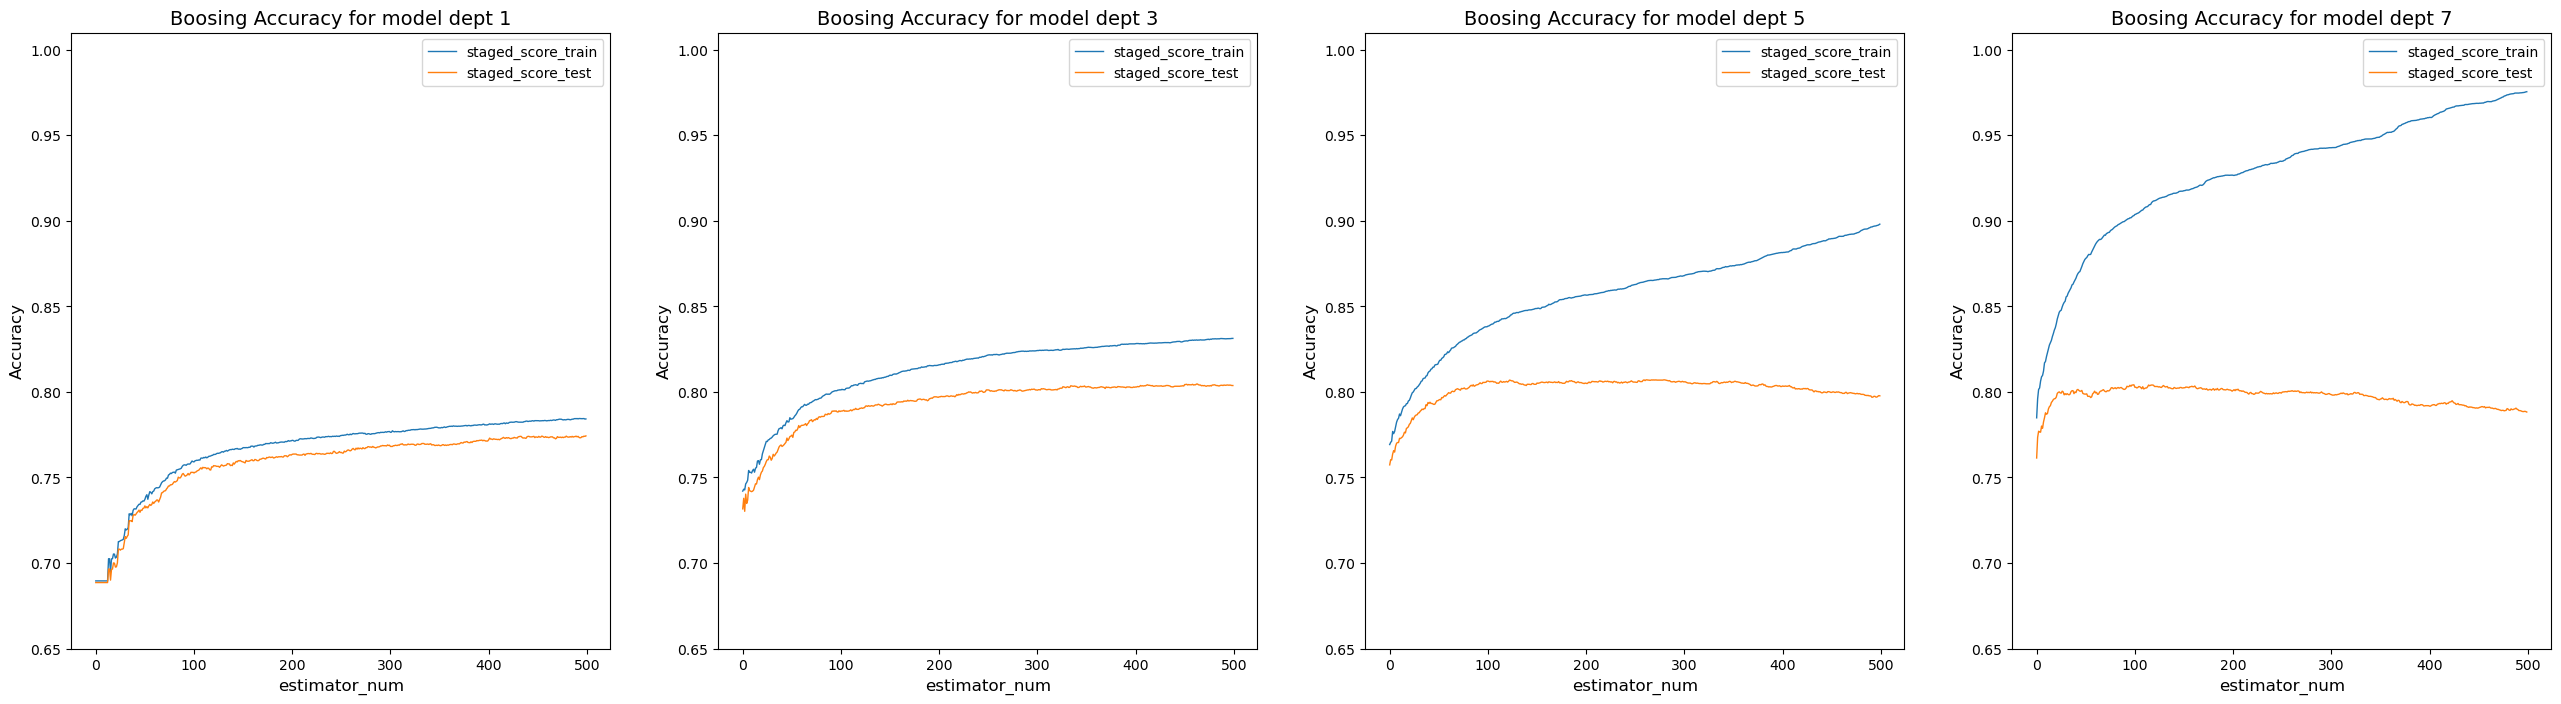

In [62]:
# Define start parameters

n_estimators=500

depth_range = [1,3,5,7]
random_state=1
learning_rate=0.05
algorithm_='SAMME.R'


### Note: This code part is intended for Q4.5
best_total_score = 0
best_score_dept = 1
best_n_estimators = 1

fig = plt.figure(figsize=(32,8))

for i,dept in enumerate(depth_range):
    
    start = timer()
    
    model_name = f'AdaBoostClassifier_{n_estimators}_estimators_{dept}_dept'
    
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=dept),
                            learning_rate=learning_rate,
                            algorithm=algorithm_,
                             n_estimators=n_estimators
                            )
    ada.fit(X_train80, y_train80)
    
    staged_score_train = list(ada.staged_score(X_train80, y_train80))
    staged_score_val = list(ada.staged_score(X_val, y_val))
    
    ### Note: This code part is intended for Q4.5
    # Check if the new max score exceeded the best score from the previous runs. If so - Update it.
    best_run_score = np.max(staged_score_val)
    if best_run_score>best_total_score:
        
        best_total_score=best_run_score
        best_score_dept=dept
        # Get the n_estimators by getting the index of the peak of the validation score 
        best_n_estimators = staged_score_val.index(best_run_score)
        
        train_score = staged_score_train[best_n_estimators]
        val_score = best_total_score
        
        ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_score_dept),
                            learning_rate=learning_rate,
                            algorithm=algorithm_,
                             n_estimators=best_n_estimators
                            )
        ada.fit(x_train_scaled, y_train)
        
        test_score = ada.score(x_test_scaled, y_test)
        
        all_model_combinations_df.at[model_name,'n_estimators']=best_n_estimators
        all_model_combinations_df.at[model_name,'random_state']=random_state
        all_model_combinations_df.at[model_name,'learning_rate']=learning_rate
        all_model_combinations_df.at[model_name,'max_depth']=best_score_dept
        all_model_combinations_df.at[model_name,'model_type']="AdaBoostClassifier"
        
        all_model_combinations_df.at[model_name,'train_score']=train_score
        all_model_combinations_df.at[model_name,'val_score']=val_score
        all_model_combinations_df.at[model_name,'test_score']=test_score
        
        yhat= ada.predict_proba(x_test_scaled)[:,1]

        fpr, tpr, thresholds = roc_curve(y_test, yhat)
        auc_result = auc(fpr,tpr)
        all_model_combinations_df.at[model_name,'auc_result']=auc_result


        all_model_combinations_df.at[model_name,'train_size']=x_train_scaled.shape[0]
        all_model_combinations_df.at[model_name,'test_size']=x_test_scaled.shape[0]
        all_model_combinations_df.at[model_name,'feature_n']=x_test_scaled.shape[1]
        
        ensemble_model_list.append({"model_name":model_name, "yhat":yhat, "auc_result":auc_result })
        
        end = timer()
        run_time_secs = round(end - start,4)
        all_model_combinations_df.at[model_name,'run_time']=run_time_secs
        
        #if dept>1:
        print(f"New best score was found of {round(best_total_score,4)} High was found for Dept: {dept}, best_n_estimators: {best_n_estimators}")
    
    ax = fig.add_subplot(1,len(depth_range),i+1)

    # Plot the training error with labels
    ax.plot(range(n_estimators), staged_score_train, label = f'staged_score_train', linewidth=1, alpha=1)
    ax.plot(range(n_estimators), staged_score_val, label = f'staged_score_test', linewidth=1, alpha=1)

    # Set the plot labels and legends
    ax.set_xlabel('estimator_num', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(f"Boosing Accuracy for model dept {dept}",fontsize=14)

    plt.ylim([0.65, 1.01])

    ax.legend()

plt.show();    
    

<br>We can observe our model in the output table:

In [63]:
print(f"The best observed accuracty was observed for dept {best_score_dept} with n_estimator {best_n_estimators}. Score: {best_total_score}")

The best observed accuracty was observed for dept 5 with n_estimator 259. Score: 0.8070074669730041


In [64]:
columns_to_display = ['train_score','val_score','test_score','auc_result','feature_n','run_time']
all_model_combinations_df[all_model_combinations_df["model_type"]=="AdaBoostClassifier"][columns_to_display].round(4)

,train_score,val_score,test_score,auc_result,feature_n,run_time
AdaBoostClassifier_500_estimators_1_dept,0.7842,0.7743,0.7819,0.8540,38.0,52.9342
AdaBoostClassifier_500_estimators_3_dept,0.8303,0.8046,0.8145,0.8871,38.0,119.9589
AdaBoostClassifier_500_estimators_5_dept,0.8643,0.8070,0.8186,0.8894,38.0,151.6993


For Boosting model we would prefer to keep our trees shallow and non-complex, since they are built sequntially and we do not want to risk ovefitting.<br>
Next, we would like to explor some highly deel trees:

<br><b>Bagging:</b><br>
In BaggingClassifier, the subsets of the training data are generated using bootstrap sampling, which means that each subset is a random sample of the training data with replacement.<br>
It involves training multiple base models independently on different subsets of the training data, and then combining the predictions of the individual base models to make a final prediction.

In [65]:
n_estimators=500
max_depth=20
random_state=1

In [66]:

base_estimator = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)


In [67]:
model_name = f'BaggingClassifier_{n_estimators}_estimators_{max_depth}_dept'

classifierModel = BaggingClassifier(base_estimator=base_estimator,
                                    random_state=random_state,
                                    n_estimators=n_estimators)

start = timer()

# Populate hyper Parameters into df
all_model_combinations_df.at[model_name,'n_estimators']=n_estimators
all_model_combinations_df.at[model_name,'random_state']=random_state
all_model_combinations_df.at[model_name,'learning_rate']=learning_rate
all_model_combinations_df.at[model_name,'max_depth']=max_depth
all_model_combinations_df.at[model_name,'model_type']="BaggingClassifier"

# Fit on entire training data
classifierModel.fit(X_train80, y_train80)

# Get model train and test scores
train_score = classifierModel.score(X_train80, y_train80)
val_score = classifierModel.score(X_val, y_val)
test_score = classifierModel.score(x_test_scaled,y_test)

all_model_combinations_df.at[model_name,'train_score']=train_score
all_model_combinations_df.at[model_name,'val_score']=val_score
all_model_combinations_df.at[model_name,'test_score']=test_score

yhat= classifierModel.predict_proba(x_test_scaled)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, yhat)
auc_result = auc(fpr,tpr)
all_model_combinations_df.at[model_name,'auc_result']=auc_result


all_model_combinations_df.at[model_name,'train_size']=X_train80.shape[0]
all_model_combinations_df.at[model_name,'test_size']=x_test_scaled.shape[0]
all_model_combinations_df.at[model_name,'feature_n']=x_test_scaled.shape[1]

ensemble_model_list.append({"model_name":model_name, "yhat":yhat, "auc_result":auc_result })

end = timer()
run_time_secs = round(end - start,4)
all_model_combinations_df.at[model_name,'run_time']=run_time_secs


print(f"{model_name} - Train: {round(train_score,3)}, Test: {round(test_score,3)}, AUC: {round(auc_result,3)}")

BaggingClassifier_500_estimators_20_dept - Train: 0.982, Test: 0.81, AUC: 0.886


In [68]:
columns_to_display = ['train_score','val_score','test_score','auc_result','feature_n','run_time']
all_model_combinations_df[columns_to_display].filter(items = [model_name], axis=0).round(4)

,train_score,val_score,test_score,auc_result,feature_n,run_time
BaggingClassifier_500_estimators_20_dept,0.9819,0.8076,0.8099,0.8859,38.0,168.919


<br><b>Bagging feature importance:</b><br>
For regular bagging the top selected feature will always be the same

In [69]:
col_names = x_train_scaled.columns

top_feature_dict = {col:0 for col in col_names}

for dtree in classifierModel.estimators_:
    top_feature_Id = dtree.tree_.feature[0]
    top_feature_name = col_names[top_feature_Id]
    
    top_feature_dict[top_feature_name]+=1
    
top_predictors_bagging = pd.DataFrame(top_feature_dict, index=["Top Count - Bagging"]).head(1).T
top_predictors_bagging.sort_values(["Top Count - Bagging"], ascending=False).head(10)

,Top Count - Bagging
instrumentalness,500
mode,0
decade_1960.0,0
key_10.0,0
key_11.0,0
time_signature_0.0,0
time_signature_1.0,0
time_signature_3.0,0
time_signature_4.0,0
time_signature_5.0,0


<br><b>Random Forest:</b><br>
Random forest uses decision trees as the base model and trains them using a random subset of the features, and it combines the predictions using a weighted averageRandom forest uses decision trees as the base model and trains them using a random subset of the features, and it combines the predictions using a weighted average.

In [70]:
n_estimators=500
max_depth=20
random_state=1

In [71]:
model_name = f'RandomForestClassifier_{n_estimators}_estimators_{max_depth}_dept'

classifierModel = RandomForestClassifier(n_estimators=n_estimators,
                                         max_depth=max_depth,
                                         max_features='sqrt', 
                                         random_state=random_state)

start = timer()

# Populate hyper Parameters into df
all_model_combinations_df.at[model_name,'n_estimators']=n_estimators
all_model_combinations_df.at[model_name,'random_state']=random_state
all_model_combinations_df.at[model_name,'learning_rate']=learning_rate
all_model_combinations_df.at[model_name,'max_depth']=max_depth
all_model_combinations_df.at[model_name,'model_type']="RandomForestClassifier"

# Fit on entire training data
classifierModel.fit(x_train_scaled, y_train)

# Get model train and test scores
train_score = classifierModel.score(X_train80, y_train80)
val_score = classifierModel.score(X_val, y_val)
test_score = classifierModel.score(x_test_scaled,y_test)

all_model_combinations_df.at[model_name,'train_score']=train_score
all_model_combinations_df.at[model_name,'val_score']=val_score
all_model_combinations_df.at[model_name,'test_score']=test_score

yhat= classifierModel.predict_proba(x_test_scaled)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, yhat)
auc_result = auc(fpr,tpr)
all_model_combinations_df.at[model_name,'auc_result']=auc_result


all_model_combinations_df.at[model_name,'train_size']=X_train80.shape[0]
all_model_combinations_df.at[model_name,'test_size']=x_test_scaled.shape[0]
all_model_combinations_df.at[model_name,'feature_n']=x_test_scaled.shape[1]

ensemble_model_list.append({"model_name":model_name, "yhat":yhat, "auc_result":auc_result })

end = timer()
run_time_secs = round(end - start,4)
all_model_combinations_df.at[model_name,'run_time']=run_time_secs


print(f"{model_name} - Train: {round(train_score,3)}, Test: {round(test_score,3)}, AUC: {round(auc_result,3)}")

RandomForestClassifier_500_estimators_20_dept - Train: 0.969, Test: 0.819, AUC: 0.897


In [72]:
columns_to_display = ['train_score','val_score','test_score','auc_result','feature_n','run_time']
all_model_combinations_df[columns_to_display].filter(items = [model_name], axis=0).round(4)

,train_score,val_score,test_score,auc_result,feature_n,run_time
RandomForestClassifier_500_estimators_20_dept,0.9693,0.971,0.8194,0.8967,38.0,41.4882


<br><b>Confusion Matrix:</b><br>
We will observe our predictions and try and see how the model preforms on each of the classes:

In [73]:
predicted_labels  = classifierModel.predict(x_test_scaled)
confusion_mat = confusion_matrix(y_test, predicted_labels)

# print the confusion matrix
pd.DataFrame(confusion_mat,columns=["P.Flop","P.Hit"],index=["Flop","Hit"])

,P.Flop,P.Hit
Flop,2318,702
Hit,408,2717


<br><b>Random Forest feature selection:</b><br>
Same as bagging, only with random feature selection

In [74]:
top_feature_dict = {col:0 for col in col_names}

for dtree in classifierModel.estimators_:
    top_feature_Id = dtree.tree_.feature[0]
    top_feature_name = col_names[top_feature_Id]
    
    top_feature_dict[top_feature_name]+=1
    
top_predictors_bagging = pd.DataFrame(top_feature_dict, index=["Top Count - Random Forest"]).head(1).T
top_predictors_bagging.sort_values(["Top Count - Random Forest"], ascending=False)

,Top Count - Random Forest
instrumentalness,79
acousticness,69
danceability,66
loudness,39
valence,38
is_missing_gender,37
duration_ms,30
speechiness,26
time_signature_4.0,21
artist_gender_Female,21


In [75]:
columns_to_run = list(top_predictors_bagging[top_predictors_bagging['Top Count - Random Forest']>10].index)
columns_to_run

['danceability',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'valence',
 'duration_ms',
 'chorus_hit',
 'is_missing_gender',
 'time_signature_3.0',
 'time_signature_4.0',
 'artist_gender_Female',
 'artist_gender_Male']

In [76]:
random_forest_model_thin = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,max_features='sqrt', random_state=random_state)
random_forest_model_thin.fit(x_train_scaled[columns_to_run],y_train)

RandomForestClassifier(max_depth=20, n_estimators=500, random_state=1)

In [77]:
model_name = f'RandomForestClassifier_Thin_{n_estimators}_estimators_{max_depth}_dept'

classifierModel = RandomForestClassifier(n_estimators=n_estimators,
                                         max_depth=max_depth,
                                         max_features='sqrt', 
                                         random_state=random_state)

start = timer()

# Populate hyper Parameters into df
all_model_combinations_df.at[model_name,'n_estimators']=n_estimators
all_model_combinations_df.at[model_name,'random_state']=random_state
all_model_combinations_df.at[model_name,'learning_rate']=learning_rate
all_model_combinations_df.at[model_name,'max_depth']=max_depth
all_model_combinations_df.at[model_name,'model_type']="RandomForestClassifier"

# Fit on entire training data
classifierModel.fit(X_train80[columns_to_run], y_train80)

# Get model train and test scores
train_score = classifierModel.score(X_train80[columns_to_run],y_train80)
val_score = classifierModel.score(X_val[columns_to_run],y_val)
test_score = classifierModel.score(x_test_scaled[columns_to_run],y_test)

all_model_combinations_df.at[model_name,'train_score']=train_score
all_model_combinations_df.at[model_name,'val_score']=val_score
all_model_combinations_df.at[model_name,'test_score']=test_score

yhat= classifierModel.predict_proba(x_test_scaled[columns_to_run])[:,1]

fpr, tpr, thresholds = roc_curve(y_test, yhat)
auc_result = auc(fpr,tpr)
all_model_combinations_df.at[model_name,'auc_result']=auc_result


all_model_combinations_df.at[model_name,'train_size']=X_train80[columns_to_run].shape[0]
all_model_combinations_df.at[model_name,'test_size']=x_test_scaled[columns_to_run].shape[0]
all_model_combinations_df.at[model_name,'feature_n']=x_test_scaled[columns_to_run].shape[1]

ensemble_model_list.append({"model_name":model_name, "yhat":yhat, "auc_result":auc_result })


end = timer()
run_time_secs = round(end - start,4)
all_model_combinations_df.at[model_name,'run_time']=run_time_secs

print(f"{model_name} - Train: {round(train_score,3)}, Test: {round(test_score,3)}, AUC: {round(auc_result,3)}")

RandomForestClassifier_Thin_500_estimators_20_dept - Train: 0.97, Test: 0.796, AUC: 0.873


In [78]:
columns_to_display = ['train_score','val_score','test_score','auc_result','feature_n','run_time']
all_model_combinations_df[columns_to_display].filter(items = [model_name], axis=0).round(4)

,train_score,val_score,test_score,auc_result,feature_n,run_time
RandomForestClassifier_Thin_500_estimators_20_dept,0.9695,0.7915,0.7961,0.8729,13.0,31.661


<br><br><b>Comparing the final results</b><br>


<br><b>Best Performing model:</b><br>
Since we collected all sort of output scores from our model, we can check and see which model performed best for each category:

"Show off" award:<br>
The award for the model with the best training score:

In [82]:
cols_to_show = ['model_type','C','penalty','solver','max_depth','n_neighbors','train_score','val_score','test_score','auc_result','run_time']
print(f"Top 3 performing models based on Train Score")
all_model_combinations_df[cols_to_show].sort_values(by='train_score', ascending=False).head(3)

Top 3 performing models based on Train Score


,model_type,C,penalty,solver,max_depth,n_neighbors,train_score,val_score,test_score,auc_result,run_time
DecisionTreeClassifier_5,DecisionTreeClassifier,NaN,NaN,NaN,50,NaN,0.999770,0.729552,0.726444,0.726896,1.8203
BaggingClassifier_500_estimators_20_dept,BaggingClassifier,NaN,NaN,NaN,20,NaN,0.981943,0.807582,0.809927,0.885893,168.9190
DecisionTreeClassifier_4,DecisionTreeClassifier,NaN,NaN,NaN,20,NaN,0.978705,0.742189,0.739951,0.725839,1.7267


Accuracy award:<br>
The award for best overall test score model (Based on proportion of correct predictions made by the classifier)

In [83]:

print(f"Top 3 performing models based on Test Score")
all_model_combinations_df[cols_to_show].sort_values(by='test_score', ascending=False).head(3)

Top 3 performing models based on Test Score


,model_type,C,penalty,solver,max_depth,n_neighbors,train_score,val_score,test_score,auc_result,run_time
RandomForestClassifier_500_estimators_20_dept,RandomForestClassifier,NaN,NaN,NaN,20,NaN,0.969306,0.970994,0.819365,0.896674,41.4882
AdaBoostClassifier_500_estimators_5_dept,AdaBoostClassifier,NaN,NaN,NaN,5,NaN,0.864302,0.807007,0.818552,0.889429,151.6993
AdaBoostClassifier_500_estimators_3_dept,AdaBoostClassifier,NaN,NaN,NaN,3,NaN,0.830342,0.804566,0.814483,0.887052,119.9589


AUC award:<br>
The award for the model best able to distinguish between the two classes by plotting the true positive rate (TPR) against the false positive rate (FPR) at different classification thresholds and calculating the area under their curve

In [84]:
print(f"Top 3 performing models based on AUC Score")
all_model_combinations_df[cols_to_show].sort_values(by='auc_result', ascending=False).head(3)

Top 3 performing models based on AUC Score


,model_type,C,penalty,solver,max_depth,n_neighbors,train_score,val_score,test_score,auc_result,run_time
RandomForestClassifier_500_estimators_20_dept,RandomForestClassifier,NaN,NaN,NaN,20,NaN,0.969306,0.970994,0.819365,0.896674,41.4882
AdaBoostClassifier_500_estimators_5_dept,AdaBoostClassifier,NaN,NaN,NaN,5,NaN,0.864302,0.807007,0.818552,0.889429,151.6993
AdaBoostClassifier_500_estimators_3_dept,AdaBoostClassifier,NaN,NaN,NaN,3,NaN,0.830342,0.804566,0.814483,0.887052,119.9589


In [79]:
def plot_roc_curve_yhat(X,Y, yhat, model_name="Classification Model"):
    
    # Plot the ROC curve
    fpr, tpr, thresholds = roc_curve(Y, yhat)
    auc_result = auc(fpr,tpr)

    x=np.arange(0,100)/100
    ax.plot(x,x,'--',color="gray",alpha=0.3)
    ax.plot(fpr,tpr,label=model_name)
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    ax.set_title(f"ROC Curve for top performing models.")
    ax.legend()
    ax.plot()

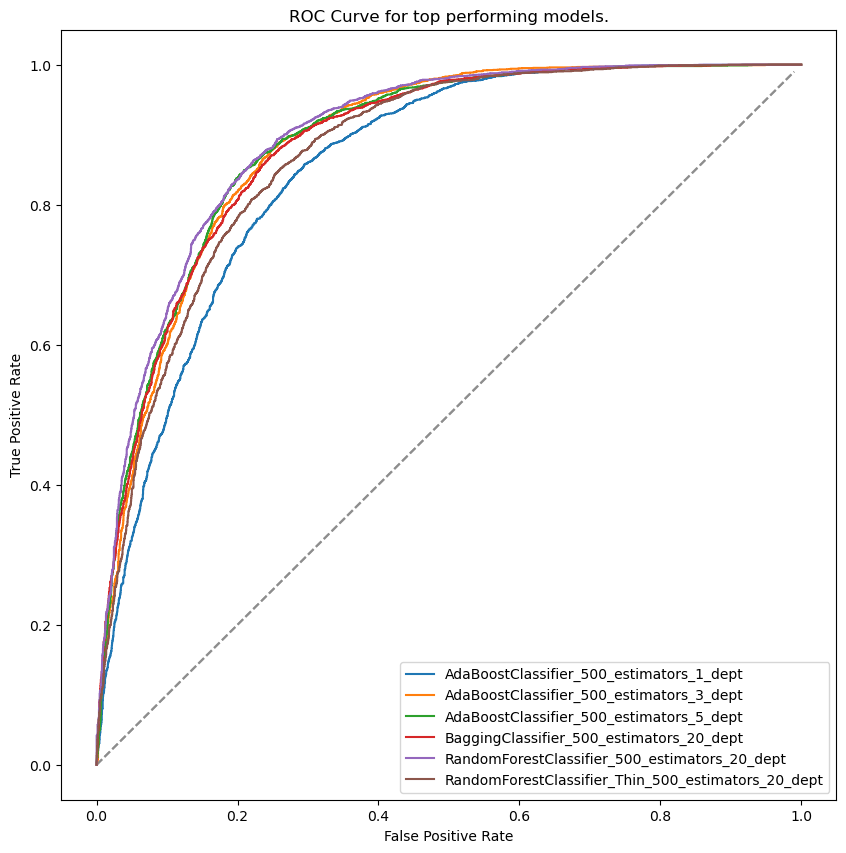

In [80]:
col_size = 2

fig, ax = plt.subplots(1,1, figsize=(10,10))

for i, item in enumerate(ensemble_model_list):
    
    model_name = item["model_name"]
    yhat_ = item["yhat"]
    auc_result_ = item['auc_result']
    
    plot_roc_curve_yhat(x_test_scaled,y_test,yhat_,model_name=model_name)


Now that we have trained and tested all our models, we can compare them to each other:

In [81]:
columns_to_display = ['train_score','val_score','test_score','auc_result','feature_n','run_time']
all_model_combinations_df[columns_to_display].sort_values(by='auc_result', ascending=False).head(15)

,train_score,val_score,test_score,auc_result,feature_n,run_time
RandomForestClassifier_500_estimators_20_dept,0.969306,0.970994,0.819365,0.896674,38.0,41.4882
AdaBoostClassifier_500_estimators_5_dept,0.864302,0.807007,0.818552,0.889429,38.0,151.6993
AdaBoostClassifier_500_estimators_3_dept,0.830342,0.804566,0.814483,0.887052,38.0,119.9589
BaggingClassifier_500_estimators_20_dept,0.981943,0.807582,0.809927,0.885893,38.0,168.9190
RandomForestClassifier_Thin_500_estimators_20_dept,0.969522,0.791499,0.796094,0.872850,13.0,31.6610
KNeighborsClassifier_4,0.769802,0.761114,0.769731,0.863065,38.0,8.1253
KNeighborsClassifier_5,0.759994,0.754739,0.765663,0.861220,38.0,8.6731
KNeighborsClassifier_3,0.791427,0.765968,0.768592,0.854944,38.0,7.3001
AdaBoostClassifier_500_estimators_1_dept,0.784176,0.774268,0.781937,0.854002,38.0,52.9342
KNeighborsClassifier_2,0.821080,0.765020,0.773963,0.842545,38.0,7.1287


When we set on our way our goal was to find the best performing model which will provide us not only with good accuracy, but also with a balances False-To-Positive ratio across different thresholds.<br>
After examining all various models and features, we have found that our most reliable model will be a RandomForestClassifier with a depth of 20 for each DecisionTree.<br>
The model should be trained on the entire dataset (regardless of feature importance) and predict with all features.<br>
